## Notes
* This notebook has implementations of `Backprop` with binary spike feature vectors obtained from the `SPIKEFLOW`. Here, we will use tf.data API. Here the shape of the inputs is `[None, n_input]` instead of `[n_input, None]`. We had to do this because nested elements in `from_tensor_slices` must have the same dimension in 0th rank [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). Everytime an iterator `iter = dataset.make_initializable_iterator()` gets initialized, the dataset is randomly shuffled so we need not shuffle again, [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). We also use `z_3 = tf.floor(z_3)`. Surrogate gradients with one step is used. (one sided)

* Here, error in the hidden layer, $\delta^{2}$ is implemented as:
$ \delta^{2} = W^{3T}\delta^{(3)}\odot\sigma^{'}(z^{(2)}) \tag{1}$
* $\sigma^{'}(z^{(2)})$ is approximated with a surrogate. (See section 6)
* It also takes care of catastrophic forgetting by using synaptic intelligence.
* He initialization without AR1 gives lesser final accuracy than Trunc init because in He the gradients don't suffer from dimnishing.
## References
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)
* [Softmax](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits)
* [SoftmaxLogits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
* [TF memory leaks when  assigning in loop](https://github.com/tensorflow/tensorflow/issues/4151)

In [1]:
import os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline
import h5py, pickle
from keras.utils.np_utils import to_categorical 
import numpy as np
import pandas as pd
import DATA_Loader
import seaborn as sb
import theano, random, sys, time

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
tf

1.14.0


<module 'tensorflow' from '/home/ruthvik/.local/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

## Hide code

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Plots

### Large

mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25

### Small

In [3]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 3.75,3
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

## Load the data 

In [4]:
filename = '../../spiking_networks/train_pool1_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_train_images = hf['pool1_spike_features'][:].astype(np.int8)
emnist_train_images[np.where(emnist_train_images>=1)] = 1

filehandle = open('../../spiking_networks/train_y.pkl','rb')
emnist_train_labels = pickle.load(filehandle).astype(np.int).tolist()
filehandle.close()
emnist_train_labels = np.array(emnist_train_labels)
print('Total train features:{}'.format(emnist_train_images.shape[0]))

#### LOAD TEST IMAGES AND LABELS
filename = '../../spiking_networks/test_pool1_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_test_images = hf['pool1_spike_features'][:].astype(np.int8)
emnist_test_images[np.where(emnist_test_images>=1)] = 1
print('Total test features:{}'.format(emnist_test_images.shape[0]))

filehandle = open('../../spiking_networks/test_y.pkl','rb')
emnist_test_labels = pickle.load(filehandle).astype(np.int)
filehandle.close()
emnist_test_labels = np.array(emnist_test_labels)

#### LOAD TRAIN AND VALIDATION DATA AND LABELS
train_images = emnist_train_images
train_labels = emnist_train_labels
train_labels = np.array(train_labels)
test_images = emnist_test_images
test_labels = emnist_test_labels
num_classes=10

Total train features:60000
Total test features:10000


In [5]:
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
              16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',
             46:'t'}

In [6]:
BATCH_SIZE = 10
#### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TRAIN DATA
def extract_class_data(start=0, stop=1):
    set1_locs = np.where((train_labels>=start) & (train_labels<=stop))[0]
    train_labels_set1 = to_categorical(train_labels[set1_locs], num_classes=num_classes)
    train_images_set1 = train_images[set1_locs,:]
    n_images = len(train_images_set1)

    #### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TEST DATA
    set1_locs = np.where((test_labels>=start) & (test_labels<=stop))[0]
    test_labels_set1 = to_categorical(test_labels[set1_locs], num_classes=num_classes)
    test_images_set1 = test_images[set1_locs,:]
    print('Test features:{}'.format(test_images_set1.shape))
    print('Length of test labels:{}'.format(test_labels_set1.shape[0]))
    test_data_set1 = (test_images_set1, test_labels_set1)
    


    train_images_set1 = train_images_set1[int(0.09*n_images):]
    train_labels_set1 = train_labels_set1[int(0.09*n_images):]
    print('Train features:{}'.format(train_images_set1.shape))
    print('Length of train labels:{}'.format(train_labels_set1.shape[0]))
    train_data_set1 = (train_images_set1, train_labels_set1)

    valid_labels_set1 = train_labels_set1[0:int(0.09*n_images)]
    valid_images_set1 = train_images_set1[0:int(0.09*n_images)]
    print('Valid features:{}'.format(valid_images_set1.shape))
    print('Length of valid labels:{}'.format(valid_labels_set1.shape[0]))
    valid_data_set1 = (valid_images_set1, valid_labels_set1)
    
    n_train_set1 = train_labels_set1.shape[0]
    n_test_set1 = test_labels_set1.shape[0]
    n_valid_set1 = valid_labels_set1.shape[0]

    return train_data_set1, valid_data_set1, test_data_set1

## Start a session

In [7]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess= tf.InteractiveSession(config=config)
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

$tanh(x) = \frac{(e^{x} – e^{-x})}{(e^{x} + e^{-x})}$

$d\frac{tanh(x)}{dx} = 1 – (tanh(x))^{2}$

$\sigma(x) = \frac{1.0}{1 + e^{-x}}$

$d\frac{\sigma(x)}{dx} = \sigma(x)*(1 - \sigma(x))$

## Setup the network graph

In [8]:
n_input = 3630
n_middle = 1024
n_out = 10
batch_size = tf.placeholder(tf.int64, name='batch_size') 
a_1 = tf.placeholder(tf.float32, [None, n_input], name = 'Input_batch')
y = tf.placeholder(tf.float32, [None, n_out], name = 'output_batch')
dataset = tf.data.Dataset.from_tensor_slices((a_1, y))
#dataset = dataset.shuffle(buffer_size=len(all_train_labels), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

drop_out = tf.placeholder(tf.float32)
tau = tf.placeholder(tf.float32)
set1_mask = tf.placeholder(tf.float32, [10], name='mask')
eta = tf.placeholder(tf.float32)
n_tot = tf.placeholder(tf.float32)
lmbda = tf.placeholder(tf.float32, name='lambda')
with tf.name_scope('hid_lyr_w_b'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(n_input + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_input + n_middle))
    
    low = -tf.math.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
    high = tf.math.sqrt(2.0/(n_input))
    
    w_2 = tf.Variable(tf.random_uniform(shape=[n_input,n_middle],minval=low,maxval=high), name = 'W_2')
    #w_2 = tf.Variable(tf.truncated_normal(shape=[n_input,n_middle], stddev=0.01),name = 'W_2')
    w_2_update_placeholder = tf.placeholder(w_2.dtype, shape=w_2.get_shape(),name='update_w2')
    w_2_update_op = w_2.assign(w_2_update_placeholder)
    tf.summary.histogram('w_2', w_2)
    
    b_2 = tf.Variable(tf.zeros([1,n_middle]), name = 'b_2')
    b_2_update_placeholder = tf.placeholder(b_2.dtype, shape=b_2.get_shape(),name='update_b2')
    b_2_update_op = b_2.assign(b_2_update_placeholder)
    tf.summary.histogram('b_2', b_2)
    
    
    w2_grad_accum = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32),name='w2_grad_accum')
    w2_grad_accum_update_placeholder=tf.placeholder(w2_grad_accum.dtype, shape=w2_grad_accum.get_shape(),
                                            name='update_w2_grad_accum')
    w2_grad_accum_update_op = w2_grad_accum.assign(w2_grad_accum_update_placeholder)
    
    
    b2_grad_accum = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='b2_grad_accum')
    b2_grad_accum_update_placeholder=tf.placeholder(b2_grad_accum.dtype,shape=b2_grad_accum.get_shape(),
                                            name='update_b2_grad_accum')
    b2_grad_accum_update_op = b2_grad_accum.assign(b2_grad_accum_update_placeholder)
    
    
    big_omeg_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='omeg_w2')
    tf.summary.histogram('big_omeg_w2', big_omeg_w2)
    big_omeg_w2_update_placeholder = tf.placeholder(big_omeg_w2.dtype, shape=big_omeg_w2.get_shape(),
                                                    name='update_big_omeg_w2')
    big_omeg_w2_update_op = big_omeg_w2.assign(big_omeg_w2_update_placeholder)
    
    
    big_omeg_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='omeg_b2')
    tf.summary.histogram('big_omeg_b2', big_omeg_b2)
    big_omeg_b2_update_placeholder = tf.placeholder(big_omeg_b2.dtype, shape=big_omeg_b2.get_shape(),
                                                    name='update_big_omeg_b2')
    big_omeg_b2_update_op = big_omeg_b2.assign(big_omeg_b2_update_placeholder)
    
    
    star_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='star_w2')
    star_w2_update_placeholder = tf.placeholder(star_w2.dtype, shape=star_w2.get_shape(),
                                                name='update_star_w2')
    star_w2_update_op = star_w2.assign(star_w2_update_placeholder)
    
    
    star_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='star_b2')
    star_b2_update_placeholder = tf.placeholder(star_b2.dtype, shape=star_b2.get_shape(),
                                                name='update_star_b2')
    star_b2_update_op = star_b2.assign(star_b2_update_placeholder)
with tf.name_scope('op_lyr_w_b'):
    
    low = -tf.math.sqrt(2.0/(n_middle))
    high = tf.math.sqrt(2.0/(n_middle))
    #w_3 = tf.Variable(tf.random_uniform(shape=[n_middle,10],minval=low,maxval=high), name = 'W_3')
    #w_3 = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3')
    w_3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32),name = 'W_3')
    tf.summary.histogram('w_3', w_3)
    w_3_update_placeholder = tf.placeholder(w_3.dtype, shape=w_3.get_shape(),name='update_w3')
    w_3_update_op = w_3.assign(w_3_update_placeholder)
    
    b_3 = tf.Variable(tf.zeros([1,n_out]), name = 'b_3')
    tf.summary.histogram('b_3', b_3)
    b_3_update_placeholder = tf.placeholder(b_3.dtype, shape=b_3.get_shape(),name='update_b3')
    b_3_update_op = b_3.assign(b_3_update_placeholder)
    
    w3_grad_accum = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='w3_grad_accum')
    b3_grad_accum = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='b3_grad_accum')
    
    big_omeg_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='omeg_w3')
    tf.summary.histogram('big_omeg_w3', big_omeg_w3)
    big_omeg_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='omeg_b3')
    tf.summary.histogram('big_omeg_b3', big_omeg_b3)
    
    star_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='star_w3')
    star_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='star_b3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

def spkNeuron(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def ReLU(x):
    return tf.maximum(0.0, x)

def ReLUprime(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def spkPrime1(x):
    l1_bound_higher = tf.greater_equal(x,-0/4)
    r1_bound_lesser = tf.less_equal(x,tau/4) 
    grad_one = tf.where(tf.logical_and(l1_bound_higher,r1_bound_lesser), tf.ones_like(x), tf.zeros_like(x))
    return grad_one

def firstLyrSpks(x):
    return tf.where(tf.greater_equal(x,1.0), tf.ones_like(x), 
                        tf.zeros_like(x))

    
with tf.name_scope('hid_lyr_acti'):
    z_2 = tf.add(tf.matmul(features,w_2,name = 'w_2xa_1'), b_2, name = 'z_2')
    locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]), tf.size(z_2))
    locs_to_drop = tf.reshape(locs_to_drop, tf.shape(z_2))
    z_2 = tf.where(locs_to_drop>0,-tf.ones_like(z_2),z_2, 'drop_out_app')
    tf.summary.histogram('z_2', z_2)
    #@a_2 = ReLU(z_2)
    a_2 = spkNeuron(z_2)
    tf.summary.histogram('a_2', a_2)
with tf.name_scope('op_lyr_acti'):
    z_3 = tf.add(tf.matmul(a_2,w_3, name = 'w_3xa_2'),b_3, name = 'z_3')
    z_3 = tf.floor(z_3)
    #z_3 = tf.subtract(tf.reduce_max(z_3),z_3, name = 'inhibition')
    tf.summary.histogram('z_3', z_3)
    #@a_3  = sigma(z_3) ##UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT spike SQUISHING
    a_3 = tf.cast(tf.nn.softmax(z_3,axis=1), tf.float32)
    a_3 = tf.multiply(a_3, set1_mask, name='masking')
    tf.summary.histogram('a_3', a_3)
    ##COMMENT THE ABOVE LINE AND UNCOMMENT BELOW LINE IF YOU WANT SOFTMAX
    #a_3 = tf.nn.softmax(z_3,axis=1) ##AXIS IS VERY IMPORTANT!!! axis=1 INDICATES THE CLASSES AS y IS [None,10]

#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
with tf.name_scope('cost_calc'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=z_3,axis=1),
                          name = 'cost_calc')#WORKS
        ##COMMENT BELOW LINES IF YOU WANT quadratic
    #@dc_da = tf.multiply(-tf.subtract(labels,a_3, name = 'y_minus_a_3'), mask)
    #@cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=1), name = 'cost_calc')
    tf.summary.scalar('cost', cost)

with tf.name_scope('op_lyr_grad'):
    #@d_z_3 = tf.multiply(-tf.subtract(labels,a_3, name = 'delta3'), mask, name='masking')
    d_z_3 = -tf.subtract(labels,a_3, name = 'delta3')
    #d_z_3 = tf.multiply(dc_da,a_3, name = 'delta3')
    d_b_3 = tf.expand_dims(tf.reduce_mean(d_z_3, axis=[0]), axis=0)
    tf.summary.histogram('d_b_3', d_b_3)
    d_w_3 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(a_2),d_z_3), 
                        name='delta_w3')
    tf.summary.histogram('d_w_3', d_w_3)
    
with tf.name_scope('hid_lyr_grad'):
    #@d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), ReLUprime(z_2),
    #@                    name = 'delta2')
    d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), spkPrime1(z_2),
                        name = 'delta2')
    #d_z_2 = tf.matmul(d_z_3,tf.transpose(w_3), name = 'delta2')
    d_b_2 = tf.expand_dims(tf.reduce_mean(d_z_2, axis=[0]), axis=0)
    tf.summary.histogram('d_b_2', d_b_2)
    d_w_2 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(features),d_z_2), 
                        name='delta_w2')
    tf.summary.histogram('d_w_2', d_w_2)
    
omega_step=[tf.assign(w2_grad_accum,
                      tf.add(w2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot, tf.square(d_w_2))),
                     name='update_omeg_w2'),
            tf.assign(b2_grad_accum,
                      tf.add(b2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot,tf.square(d_b_2))),
                     name='update_omeg_b2')
]

step = [tf.assign(w_2,
                  tf.subtract(w_2, (eta*d_w_2+big_omeg_w2*(w_2-star_w2))),name='update_w_2'),
        tf.assign(b_2,
                  tf.subtract(b_2,(eta*d_b_2+big_omeg_b2*(b_2-star_b2))),name='update_b_2'),
        
        tf.assign(w_3,
                  tf.subtract(w_3, (eta*d_w_3+big_omeg_w3*(w_3-star_w3))),name='update_w_3'),
        tf.assign(b_3,
                  tf.subtract(b_3,(eta*d_b_3+big_omeg_b3*(b_3-star_b3))),name='update_b_3')    
]
with tf.name_scope('acc_calc'):
    predictions = tf.argmax(a_3, 1)
    acct_mat = tf.equal(tf.argmax(a_3, 1), tf.argmax(labels, 1))
    acct_res = tf.reduce_mean(tf.cast(acct_mat, tf.float32))
    tf.summary.scalar('accuracy', acct_res)

init_op = tf.global_variables_initializer()

### Init the writer with $\lambda$s (0, 6.75)e4

In [10]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_sh_16lmbdas_ar1_3lyrs_he1', sess.graph)

### Generate $\lambda$s 

In [11]:
np.random.seed(100)
n_lmbdas = 15
a = np.random.uniform(low=0.0, high=6.75, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[3.66798336 1.87899335 2.86549374 5.70223889 0.03185228 0.82059157
 4.52755632 5.5745061  0.92276948 3.88187997 6.01642319 1.41211432
 1.25096548 0.73154401 1.48295808]
()
[  318.52279289  7315.44010634  8205.91565286  9227.69480373
 12509.65481963 14121.14324291 14829.58075219 18789.93349383
 28654.93737557 36679.83357089 38818.79973634 45275.56321906
 55745.06096959 57022.38893159 60164.23191608]
()
([0, 318.52279289064813, 7315.4401063372225, 8205.915652860209, 9227.694803734325, 12509.654819630066, 14121.143242910297, 14829.58075218697, 18789.933493831242, 28654.937375566486, 36679.833570890165, 38818.79973633937, 45275.563219057556, 55745.06096959071, 57022.388931593494, 60164.23191607782, 0, 318.52279289064813, 7315.4401063372225, 8205.915652860209, 9227.694803734325, 12509.654819630066, 14121.143242910297, 14829.58075218697, 18789.933493831242, 28654.937375566486, 36679.833570890165, 38818.79973633937, 45275.563219057556, 55745.06096959071, 57022.388931593494, 60164.23191607782,

### Generate random weights

In [12]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(80, 80)


In [13]:
np.array_equal(np_weights[0], np_weights[15])

True

In [14]:
np.array_equal(np_weights[0], np_weights[16])

False

### Commence training

In [15]:
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()

Training with lmbda:0, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.9

Training on :(8, 9)
training cost:0.0535054244101 and training accuracy:0.985285878181
validation cost:0.0488348640501 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0479301735759 and training accuracy:0.986775934696
validation cost:0.0455383919179 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0442771986127 and training accuracy:0.987520933151
validation cost:0.0432717837393 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0408748500049 and training accuracy:0.988359093666
validation cost:0.0389142967761 and validation accuracy:0.993408679962
Training on :(8, 9)
Time taken:128.926782846
Method 3 test accuracy:0.78979998827
Training with lmbda:318.522792891, 1
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339

Training on :(8, 9)
training cost:0.151472836733 and training accuracy:0.965263545513
validation cost:0.147377207875 and validation accuracy:0.966101706028
Training on :(8, 9)
training cost:0.103573098779 and training accuracy:0.972713708878
validation cost:0.10354039818 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0824561417103 and training accuracy:0.976066291332
validation cost:0.0788237005472 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0692244544625 and training accuracy:0.979791402817
validation cost:0.0633962526917 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.059490069747 and training accuracy:0.983237087727
validation cost:0.0546964928508 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0533672757447 and training accuracy:0.985285878181
validation cost:0.0488668456674 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.047845300287 and train

Training on :(6, 7)
training cost:0.00988424755633 and training accuracy:0.999098062515
validation cost:0.0102383000776 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00883597321808 and training accuracy:0.999098062515
validation cost:0.00859887711704 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:121.652678013
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.15136988461 and training accuracy:0.964984178543
validation cost:0.148393079638 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.103539772332 and training accuracy:0.972434341908
validation cost:0.102035716176 and validation accuracy:0.9745

Training on :(6, 7)
training cost:0.0241417139769 and training accuracy:0.997745096684
validation cost:0.024643426761 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.019125521183 and training accuracy:0.998015701771
validation cost:0.0193141885102 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0155282784253 and training accuracy:0.998286306858
validation cost:0.0160127580166 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0129362177104 and training accuracy:0.9987372756
validation cost:0.0134760057554 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0111363437027 and training accuracy:0.998827457428
validation cost:0.0119296777993 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00985618215054 and training accuracy:0.999098062515
validation cost:0.0102367522195 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.008818378672 and tr

Training on :(4, 5)
Time taken:113.042720795
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0638147220016 and training accuracy:0.991431415081
validation cost:0.0632113814354 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0341522954404 and training accuracy:0.997294127941
validation cost:0.0343139767647 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0242036189884 and training accuracy:0.997925519943
validation cost:0.0244181770831 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0189443659037 and training accuracy:0.997925519943
validation cost:0.0194039661437 and validation accuracy:0.995

Training on :(4, 5)
training cost:0.0236765164882 and training accuracy:0.997853636742
validation cost:0.0181112382561 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0199190527201 and training accuracy:0.998341441154
validation cost:0.0147758722305 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0170001611114 and training accuracy:0.998341441154
validation cost:0.012366569601 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0154246380553 and training accuracy:0.997853636742
validation cost:0.0112634934485 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0140442205593 and training accuracy:0.998146355152
validation cost:0.0101188346744 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.852390051
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0989918932319 and training accuracy:0.991609752178
validation cost:0.091744363308 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0540550015867 and training accuracy:0.99287801981
validation cost:0.0476841889322 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0378479473293 and training accuracy:0.994634151459
validation cost:0.0303050130606 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0291291959584 and training accuracy:0.99658536911
validation cost:0.0222821366042 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0236534923315 and training accuracy:0.997853636742
validation cost:0.0180211886764 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0199630148709 and training accuracy:0.998341441154
validation cost:0.0147312618792 and va

Training on :(2, 3)
training cost:0.0513002499938 and training accuracy:0.982910633087
validation cost:0.050956338644 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0465157516301 and training accuracy:0.985637664795
validation cost:0.0468412488699 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.0429077409208 and training accuracy:0.987273871899
validation cost:0.0414585731924 and validation accuracy:0.987132370472
Training on :(2, 3)
Time taken:120.226647139
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0989998206496 and training accuracy:0.991609752178
validation cost:0.0916628539562 and validation accuracy:0.997038483

Training on :(2, 3)
training cost:0.113364562392 and training accuracy:0.968548297882
validation cost:0.12098506093 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0885561406612 and training accuracy:0.97309333086
validation cost:0.0924739167094 and validation accuracy:0.967830896378
Training on :(2, 3)
training cost:0.0737892091274 and training accuracy:0.974184155464
validation cost:0.0788468718529 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0644843131304 and training accuracy:0.977365672588
validation cost:0.0673433989286 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0564459450543 and training accuracy:0.9806381464
validation cost:0.0583137944341 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.051290538162 and training accuracy:0.982819736004
validation cost:0.0505184829235 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0465791411698 and training acc

Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:126.32477808
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.168316215277 and training accuracy:0.950004518032
validation cost:0.169079318643 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.113381847739 and training accuracy:0.968548297882
validation cost:0.12098506093 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0885733067989 and training accuracy:0.97309333086
validation cost:0.0924739167094 and validation accuracy:0.9678308

Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997744202614
validation cost:0.00971961114556 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00863864738494 and training accuracy:0.998004496098
validation cost:0.0086479568854 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00776934204623 and training accuracy:0.99809128046
validation cost:0.0084388460964 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:126.446883917
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997

training cost:0.0483522415161 and training accuracy:0.986682832241
validation cost:0.0454847961664 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0445359498262 and training accuracy:0.987707197666
validation cost:0.0415289700031 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0408991575241 and training accuracy:0.988359093666
validation cost:0.0391653738916 and validation accuracy:0.992467045784
Training on :(8, 9)
Time taken:117.765272856
Method 3 test accuracy:0.783500015736
Training with lmbda:45275.5632191, 12
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accura

Training on :(8, 9)
training cost:0.103793106973 and training accuracy:0.972061812878
validation cost:0.100347965956 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0822403505445 and training accuracy:0.975880026817
validation cost:0.0786894857883 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0691204816103 and training accuracy:0.979791402817
validation cost:0.0634864270687 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.060049276799 and training accuracy:0.983423352242
validation cost:0.0552336461842 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0533308051527 and training accuracy:0.985379040241
validation cost:0.050281342119 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0484713725746 and training accuracy:0.986589670181
validation cost:0.0455383434892 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.044461145997 and train

Training on :(6, 7)
training cost:0.00908142607659 and training accuracy:0.999098062515
validation cost:0.00878660194576 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:121.50276804
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153453245759 and training accuracy:0.964704811573
validation cost:0.148792400956 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.103723436594 and training accuracy:0.972248077393
validation cost:0.100438781083 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.08261243999 and training accuracy:0.975600659847
validation cost:0.0797011777759 and validation accuracy:0.979284346

Training on :(6, 7)
training cost:0.0189655944705 and training accuracy:0.998105883598
validation cost:0.0190979149193 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0156312976032 and training accuracy:0.998196065426
validation cost:0.0163305066526 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0131931435317 and training accuracy:0.9987372756
validation cost:0.0132242999971 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0113306669518 and training accuracy:0.9987372756
validation cost:0.0116669768468 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.010006451048 and training accuracy:0.998917639256
validation cost:0.0103530595079 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00903469603509 and training accuracy:0.999098062515
validation cost:0.00874926149845 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:121.423624039
Current ma

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0639605298638 and training accuracy:0.991250991821
validation cost:0.0632901266217 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0342638269067 and training accuracy:0.997203946114
validation cost:0.0344367735088 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0241608824581 and training accuracy:0.997925519943
validation cost:0.0248610507697 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0188748743385 and training accuracy:0.998105883598
validation cost:0.0191118586808 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.015687244013 and training accuracy:0.998196065426
validation cost:0.0163077488542 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0131380818784 and training accuracy:0.9987372756
validation cost

training cost:0.0209832713008 and training accuracy:0.996975600719
validation cost:0.0149554889649 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0183575861156 and training accuracy:0.997365832329
validation cost:0.0124804545194 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0164001379162 and training accuracy:0.997560977936
validation cost:0.0110024530441 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149549171329 and training accuracy:0.997463405132
validation cost:0.0095500042662 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.212858915
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620987862349 and

Training on :(4, 5)
training cost:0.100126810372 and training accuracy:0.991414606571
validation cost:0.0899167507887 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0545816011727 and training accuracy:0.993073165417
validation cost:0.0473784282804 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0395342633128 and training accuracy:0.995024383068
validation cost:0.0320389680564 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0308352075517 and training accuracy:0.996292710304
validation cost:0.023763589561 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0251379031688 and training accuracy:0.996292710304
validation cost:0.0194510221481 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0209808852524 and training accuracy:0.996975600719
validation cost:0.0149645060301 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0183092635125 and training ac

training cost:0.0520863197744 and training accuracy:0.984910488129
validation cost:0.0572169162333 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0474901460111 and training accuracy:0.986092150211
validation cost:0.0527139976621 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.0441380105913 and training accuracy:0.987637460232
validation cost:0.048333209008 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:121.050490856
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0999810248613 and training accuracy:0.991804897785
validation cost:0.0896395370364 and validation accuracy:0.995064139366
Training o

Training on :(2, 3)
training cost:0.116149045527 and training accuracy:0.96891194582
validation cost:0.119582034647 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0904788970947 and training accuracy:0.974638640881
validation cost:0.0987908989191 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0757415294647 and training accuracy:0.977092981339
validation cost:0.0860173627734 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0662310495973 and training accuracy:0.979001879692
validation cost:0.0742289721966 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0591368302703 and training accuracy:0.982183456421
validation cost:0.0654713883996 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0522213727236 and training accuracy:0.984819591045
validation cost:0.0572488605976 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0475407429039 and t

training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:126.286984921
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172586724162 and training accuracy:0.948186516762
validation cost:0.175913929939 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116149045527 and training accuracy:0.96891194582
validation cost:0.119582034647 and validation accuracy:0.964154422283
Training on

Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155

Training on :(8, 9)
Time taken:120.481314898
Method 3 test accuracy:0.791499972343
Training with lmbda:14121.1432429, 22
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 and training accuracy:0.99514144659
validation cost:0.0417454019189 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0227200146765 and training accuracy:0.994967877865
validation cost:0.0239276178181 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 

Training on :(8, 9)
training cost:0.0615483894944 and training accuracy:0.982212722301
validation cost:0.059198319912 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0551306940615 and training accuracy:0.984354615211
validation cost:0.0522239170969 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.0492140129209 and training accuracy:0.985844671726
validation cost:0.0474375337362 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.044388461858 and training accuracy:0.987055301666
validation cost:0.0426999218762 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0403650738299 and training accuracy:0.988265991211
validation cost:0.0395393259823 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:118.189106941
Method 3 test accuracy:0.786099970341
Training with lmbda:14829.5807522, 23
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test label

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153816148639 and training accuracy:0.963214755058
validation cost:0.153117462993 and validation accuracy:0.961393594742
Training on :(8, 9)
training cost:0.104858569801 and training accuracy:0.968988656998
validation cost:0.102057896554 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0837670266628 and training accuracy:0.975228190422
validation cost:0.0830205902457 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0702793598175 and training accuracy:0.979418873787
validation cost:0.0696703419089 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0615342594683 and training accuracy:0.982119560242
validation cost:0.0596029125154 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0551932863891 and training accuracy:0.984447777271
validation cost:

Training on :(6, 7)
training cost:0.0111367572099 and training accuracy:0.999007821083
validation cost:0.0107680410147 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0098322480917 and training accuracy:0.999098062515
validation cost:0.0100724035874 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00897537451237 and training accuracy:0.99927842617
validation cost:0.00892462115735 and validation accuracy:1.0
Training on :(6, 7)
Time taken:122.170909166
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.15371260047 and training accuracy:0.963401019573
validation cost:0.152765482664 and validation accuracy:0.961393594742
Tr

Training on :(6, 7)
training cost:0.034116897732 and training accuracy:0.997654914856
validation cost:0.0347194820642 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0240002460778 and training accuracy:0.998105883598
validation cost:0.0244227107614 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0185022354126 and training accuracy:0.998647093773
validation cost:0.018949162215 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0150814484805 and training accuracy:0.998647093773
validation cost:0.0152597930282 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0128386821598 and training accuracy:0.998827457428
validation cost:0.0130059467629 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0111534651369 and training accuracy:0.999007821083
validation cost:0.0109174335375 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00986880995333 and train

Training on :(4, 5)
training cost:0.016719661653 and training accuracy:0.997560977936
validation cost:0.0112298447639 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0151301696897 and training accuracy:0.997560977936
validation cost:0.00964047480375 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.764501095
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620635561645 and training accuracy:0.992603957653
validation cost:0.0625883489847 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0341623574495 and training accuracy:0.997564733028
validation cost:0.0345652736723 and validation accuracy:0.999087572098
Training on

Training on :(4, 5)
training cost:0.0396576188505 and training accuracy:0.994829297066
validation cost:0.0322456881404 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0311093777418 and training accuracy:0.995999991894
validation cost:0.0240888167173 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0254214759916 and training accuracy:0.996292710304
validation cost:0.019578339532 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0211355183274 and training accuracy:0.996975600719
validation cost:0.0151416193694 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0184242501855 and training accuracy:0.997560977936
validation cost:0.0128741655499 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0167547315359 and training accuracy:0.997463405132
validation cost:0.010931039229 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.015101919882 and training accuracy:0.997756123543
v

training cost:0.0443618632853 and training accuracy:0.987455666065
validation cost:0.0490240976214 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:120.505398035
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.100013934076 and training accuracy:0.991609752178
validation cost:0.0893259271979 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0546714700758 and training accuracy:0.992975592613
validation cost:0.0472962036729 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0396246537566 and training accuracy:0.995024383068
validation cost:0.0321504175663 and validation accuracy:0.998025655746
Training o

Training on :(2, 3)
training cost:0.0759068205953 and training accuracy:0.976729393005
validation cost:0.0861033350229 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0663100928068 and training accuracy:0.978820085526
validation cost:0.0746524333954 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0591175407171 and training accuracy:0.982456147671
validation cost:0.0653562918305 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0523256994784 and training accuracy:0.985001385212
validation cost:0.0572704859078 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0473319552839 and training accuracy:0.986001253128
validation cost:0.0526042282581 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.0444595068693 and training accuracy:0.987364768982
validation cost:0.0491150841117 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:120.918208122
Current

Time taken:126.452954769
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172655671835 and training accuracy:0.948277413845
validation cost:0.17598554492 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116085350513 and training accuracy:0.968639194965
validation cost:0.119249850512 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0904999151826 and training accuracy:0.974638640881
validation cost:0.0984914898872 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0756558775902 and training accuracy:0.977183878422
validation cost:0.0858241021633 and validation accuracy:0.970588207245
Training on :(

Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:126.461848974
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Va

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.99

Training on :(8, 9)
training cost:0.0485742762685 and training accuracy:0.986030936241
validation cost:0.0470215454698 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0444778949022 and training accuracy:0.987148463726
validation cost:0.0425119064748 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0412655323744 and training accuracy:0.988359093666
validation cost:0.039038259536 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:118.122453928
Method 3 test accuracy:0.787899971008
Training with lmbda:318.522792891, 33
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 

Training on :(8, 9)
training cost:0.102530695498 and training accuracy:0.971968710423
validation cost:0.102527581155 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0834567174315 and training accuracy:0.975600659847
validation cost:0.0835453793406 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0699967294931 and training accuracy:0.978766977787
validation cost:0.0695092007518 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0606748685241 and training accuracy:0.982026457787
validation cost:0.0593354403973 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0541148744524 and training accuracy:0.983982145786
validation cost:0.0518507026136 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0486207529902 and training accuracy:0.985751509666
validation cost:0.0474768951535 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0444009080529 and t

Training on :(6, 7)
training cost:0.00861151888967 and training accuracy:0.999098062515
validation cost:0.00871124211699 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:121.661106825
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150438115001 and training accuracy:0.963214755058
validation cost:0.148587688804 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.102669894695 and training accuracy:0.971968710423
validation cost:0.102246038616 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0832442939281 and training accuracy:0.975414395332
validation cost:0.0836543366313 and validation accuracy:0.97740

Training on :(6, 7)
training cost:0.018265042454 and training accuracy:0.998286306858
validation cost:0.0184528678656 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0148086510599 and training accuracy:0.998286306858
validation cost:0.0142932645977 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0126848593354 and training accuracy:0.998556852341
validation cost:0.0129027906805 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0109691824764 and training accuracy:0.998917639256
validation cost:0.0109466733411 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00978331267834 and training accuracy:0.999098062515
validation cost:0.0101170074195 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00862791202962 and training accuracy:0.999098062515
validation cost:0.00865565985441 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:121.992592812
Current

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0619770810008 and training accuracy:0.991972565651
validation cost:0.0612336583436 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.0337977446616 and training accuracy:0.997113764286
validation cost:0.0352673046291 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.023487970233 and training accuracy:0.998196065426
validation cost:0.0246037598699 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0183280743659 and training accuracy:0.998376488686
validation cost:0.0185248758644 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0148234311491 and training accuracy:0.998286306858
validation cost:0.0142504023388 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0126727661118 and training accuracy:0.998556852341
validation c

Training on :(4, 5)
training cost:0.0174313671887 and training accuracy:0.998243927956
validation cost:0.013257978484 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0157319940627 and training accuracy:0.998439013958
validation cost:0.0125356428325 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0141888810322 and training accuracy:0.998536586761
validation cost:0.0112034985796 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.672134876
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.061915975064 and training accuracy:0.991972565651
validation cost:0.0609783530235 and validation accuracy:0.991788327694
Training on :(6, 7)
trai

Training on :(4, 5)
training cost:0.0526391379535 and training accuracy:0.994926810265
validation cost:0.0474383160472 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0377746932209 and training accuracy:0.996097564697
validation cost:0.0323411002755 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0286552384496 and training accuracy:0.997658550739
validation cost:0.0237779002637 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0235775168985 and training accuracy:0.997560977936
validation cost:0.0190748441964 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0200517959893 and training accuracy:0.997951209545
validation cost:0.0151044707745 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0174853652716 and training accuracy:0.998243927956
validation cost:0.0133407004178 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0156553834677 and training accuracy:0.998439013958
validation cost:0.01

Training on :(2, 3)
training cost:0.0427206642926 and training accuracy:0.986728489399
validation cost:0.0421030670404 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:120.779515982
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.096432864666 and training accuracy:0.993365824223
validation cost:0.0909444391727 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0526186339557 and training accuracy:0.994926810265
validation cost:0.0472542829812 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0378435105085 and training accuracy:0.995999991894
validation cost:0.0323789976537 and validation accuracy:1.0
T

Training on :(2, 3)
training cost:0.0705200359225 and training accuracy:0.977274775505
validation cost:0.0716834515333 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0619650036097 and training accuracy:0.979001879692
validation cost:0.063658721745 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.05472022295 and training accuracy:0.981819808483
validation cost:0.0561834610999 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0495570115745 and training accuracy:0.984092354774
validation cost:0.0492137745023 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0463130436838 and training accuracy:0.984728634357
validation cost:0.0464502573013 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0423749051988 and training accuracy:0.987001180649
validation cost:0.0424100570381 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:121.215496063
Current ma

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160525530577 and training accuracy:0.955185890198
validation cost:0.161406889558 and validation accuracy:0.956801474094
Training on :(2, 3)
training cost:0.106987677515 and training accuracy:0.971184432507
validation cost:0.106891572475 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0833403021097 and training accuracy:0.975002288818
validation cost:0.0826154351234 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0705836489797 and training accuracy:0.977183878422
validation cost:0.0716642066836 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0619399696589 and training accuracy:0.97909283638
validation cost:0.0636349767447 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.054816853255 and training accuracy:0.981910765171
validation cost:0

Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 and training accuracy:0.99809128046
validation cost:0.0103809628636 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00715233804658 and training accuracy:0.998178005219
validation cost:0.0096391858533 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:126.116593122
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160525530577 and training accuracy:0.955185890198
validation cost:0.161406889558 and validation accuracy:0.95

Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.997917771339
validation cost:0.013716164045 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 a

Training on :(8, 9)
training cost:0.0418185591698 and training accuracy:0.987893462181
validation cost:0.0400071367621 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:118.256458998
Method 3 test accuracy:0.786400020123
Training with lmbda:45275.5632191, 44
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587

Training on :(8, 9)
training cost:0.069791443646 and training accuracy:0.978953242302
validation cost:0.0684397742152 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0608754232526 and training accuracy:0.982026457787
validation cost:0.0588055066764 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0540161244571 and training accuracy:0.983982145786
validation cost:0.0513063743711 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.048902772367 and training accuracy:0.985751509666
validation cost:0.0466610714793 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0444310121238 and training accuracy:0.987334728241
validation cost:0.0428877659142 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0418405495584 and training accuracy:0.988172829151
validation cost:0.0400366596878 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:117.861140013
Method 3 

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.149996340275 and training accuracy:0.963959753513
validation cost:0.147390350699 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.102863714099 and training accuracy:0.972154974937
validation cost:0.102561824024 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.083615899086 and training accuracy:0.975973188877
validation cost:0.0844724327326 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0700719803572 and training accuracy:0.978580713272
validation cost:0.0689814314246 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0607537552714 and training accuracy:0.982119560242
validation cost:0.0585863143206 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0543346256018 and training accuracy:0.984075248241
validation cost:0

Training on :(6, 7)
training cost:0.0111195631325 and training accuracy:0.998917639256
validation cost:0.0112301958725 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0098137781024 and training accuracy:0.999098062515
validation cost:0.0099175684154 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00879005435854 and training accuracy:0.999098062515
validation cost:0.00890683289617 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:121.762551069
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150125429034 and training accuracy:0.963680386543
validation cost:0.148038029671 and validation accuracy:0.9642

Training on :(6, 7)
training cost:0.0337890721858 and training accuracy:0.997023522854
validation cost:0.035351138562 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0234273541719 and training accuracy:0.998196065426
validation cost:0.0244155880064 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0183205008507 and training accuracy:0.998376488686
validation cost:0.0188477095217 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.014861931093 and training accuracy:0.998376488686
validation cost:0.0144215095788 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0127490246668 and training accuracy:0.998556852341
validation cost:0.0128457369283 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0111612612382 and training accuracy:0.998917639256
validation cost:0.0114140026271 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00991629622877 and t

Training on :(4, 5)
training cost:0.0152014484629 and training accuracy:0.997463405132
validation cost:0.0111647546291 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:113.405771971
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680197104812 and training accuracy:0.990258872509
validation cost:0.0667800009251 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364416614175 and training accuracy:0.996392190456
validation cost:0.0359052494168 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0257732402533 and training accuracy:0.997384309769
validation cost:0.0257938690484 and validation accuracy:0.998

Training on :(4, 5)
training cost:0.0294880736619 and training accuracy:0.996682941914
validation cost:0.0219154953957 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0243707187474 and training accuracy:0.997170746326
validation cost:0.0177403576672 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0211981907487 and training accuracy:0.997463405132
validation cost:0.0151897370815 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.018980724737 and training accuracy:0.99726831913
validation cost:0.0134885795414 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0169548820704 and training accuracy:0.997365832329
validation cost:0.0123119493946 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0152132986113 and training accuracy:0.997463405132
validation cost:0.0111348340288 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:112.746743917
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0

Time taken:120.997966051
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.09499797225 and training accuracy:0.992292702198
validation cost:0.0884245038033 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0528650432825 and training accuracy:0.993073165417
validation cost:0.0452229753137 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.037450004369 and training accuracy:0.995024383068
validation cost:0.0303481537849 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0293159652501 and training accuracy:0.996878027916
validation cost:0.0219632312655 and validation accuracy:1.0
Training on :(4, 5)
trai

Training on :(2, 3)
training cost:0.0611424557865 and training accuracy:0.979729115963
validation cost:0.0678342655301 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537426732481 and training accuracy:0.982456147671
validation cost:0.0582773573697 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0491536073387 and training accuracy:0.984455943108
validation cost:0.0527291372418 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0452709421515 and training accuracy:0.985728561878
validation cost:0.0492718741298 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0416040569544 and training accuracy:0.987182974815
validation cost:0.0460423231125 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:121.856167078
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid fe

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162115871906 and training accuracy:0.953822374344
validation cost:0.167495980859 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.108130030334 and training accuracy:0.97154802084
validation cost:0.109002113342 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0837637484074 and training accuracy:0.976365804672
validation cost:0.0885929092765 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0696206092834 and training accuracy:0.977820217609
validation cost:0.0767484158278 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0609808117151 and training accuracy:0.979820013046
validation cost:0.067244514823 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0538365915418 and training accuracy:0.982365250587
validation cost:0.058244

Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 and training accuracy:0.99809128046
validation cost:0.0085003040731 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:126.424232006
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162115871906 and training accuracy:0.953822374344
validation cost:0.167495980859 and validation accuracy:0.9

Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 and training accuracy:0.996616363525
validation cost:0.0185922384262 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0130954766646 and training accuracy:0.998004496098
validation cost:0.0150229362771 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998178005219
validation cost:0.0100549636409 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 

Training on :(8, 9)
training cost:0.0430474579334 and training accuracy:0.987520933151
validation cost:0.0409238599241 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:118.569076061
Method 3 test accuracy:0.787599980831
Training with lmbda:14829.5807522, 55
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062 and training accuracy:0.995228171349
validation cost:0.0439142361283 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 a

Training on :(8, 9)
training cost:0.0727451443672 and training accuracy:0.978208243847
validation cost:0.0730718150735 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0631366819143 and training accuracy:0.982119560242
validation cost:0.0637478083372 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0565294809639 and training accuracy:0.984168350697
validation cost:0.0556199736893 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0510895736516 and training accuracy:0.985379040241
validation cost:0.0494109578431 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0465335324407 and training accuracy:0.986775934696
validation cost:0.0439791753888 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0429053790867 and training accuracy:0.987520933151
validation cost:0.0400900244713 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:117.828014851
Method 3

Training on :(6, 7)
Time taken:121.907500029
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150270164013 and training accuracy:0.963773488998
validation cost:0.152108892798 and validation accuracy:0.958568751812
Training on :(8, 9)
training cost:0.104814402759 and training accuracy:0.972248077393
validation cost:0.107460066676 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0849664658308 and training accuracy:0.974762499332
validation cost:0.084878526628 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0726746916771 and training accuracy:0.978301346302
validation cost:0.0731333941221 and validation accuracy:0.9792843

Training on :(6, 7)
training cost:0.0160866938531 and training accuracy:0.998196065426
validation cost:0.0154011612758 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0135535756126 and training accuracy:0.998466670513
validation cost:0.0138618536294 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.011541380547 and training accuracy:0.998556852341
validation cost:0.0116321565583 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0102827521041 and training accuracy:0.998647093773
validation cost:0.0106787281111 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00933049153537 and training accuracy:0.9987372756
validation cost:0.00958501640707 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:122.115272045
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid fea

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680602043867 and training accuracy:0.990258872509
validation cost:0.0669418722391 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364418625832 and training accuracy:0.996482372284
validation cost:0.0357679873705 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0259940512478 and training accuracy:0.997294127941
validation cost:0.0258670300245 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0201300289482 and training accuracy:0.997745096684
validation cost:0.0193624347448 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0161209143698 and training accuracy:0.998105883598
validation cost:0.0154650593176 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0135559113696 and training accuracy:0.998556852341
validation cost:

Training on :(4, 5)
training cost:0.0189097952098 and training accuracy:0.997463405132
validation cost:0.0134053658694 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0170930307359 and training accuracy:0.99726831913
validation cost:0.0125577170402 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0154857933521 and training accuracy:0.997463405132
validation cost:0.0108912186697 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:112.549488068
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680212527514 and training accuracy:0.990349054337
validation cost:0.066829957068 and validation accuracy:0.98813867569
Tra

Training on :(4, 5)
training cost:0.0530794411898 and training accuracy:0.993073165417
validation cost:0.0454771518707 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.037420861423 and training accuracy:0.994926810265
validation cost:0.0299726072699 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0295207705349 and training accuracy:0.996780514717
validation cost:0.0221221260726 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0245544929057 and training accuracy:0.997073173523
validation cost:0.0181762613356 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0215311329812 and training accuracy:0.99726831913
validation cost:0.0153397191316 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0189435072243 and training accuracy:0.997463405132
validation cost:0.0133904665709 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0171835385263 and training accuracy:0.99726831913
va

training cost:0.0454221516848 and training accuracy:0.985728561878
validation cost:0.0494114011526 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0414363481104 and training accuracy:0.987092077732
validation cost:0.0464083105326 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:120.737991095
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0953279733658 and training accuracy:0.991999983788
validation cost:0.0895662456751 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0530065484345 and training accuracy:0.992975592613
validation cost:0.0451232530177 and validation accuracy:0.99703848362
Training o

Training on :(2, 3)
training cost:0.0837248042226 and training accuracy:0.976184010506
validation cost:0.0887720882893 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0696736127138 and training accuracy:0.977820217609
validation cost:0.0767827033997 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0611455924809 and training accuracy:0.979729115963
validation cost:0.0678301826119 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537644661963 and training accuracy:0.982456147671
validation cost:0.0577355995774 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.049286890775 and training accuracy:0.984274148941
validation cost:0.0533486604691 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0453134737909 and training accuracy:0.985819458961
validation cost:0.0497581399977 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0415504612029 and

Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:126.063431025
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162090584636 and training accuracy:0.953822374344
validation cost:0.167213529348 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.108071632683 and training accuracy:0.971457123756
validation cost:0.10907522589 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0837088674307 and training accuracy:0.976274907589
validation cost:0.0887720882893 and validation accuracy:0.970588207245


Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:126.185282946
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.9

training cost:0.0489648133516 and training accuracy:0.985844671726
validation cost:0.0490796528757 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0448433347046 and training accuracy:0.987707197666
validation cost:0.0446303412318 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0413806848228 and training accuracy:0.987893462181
validation cost:0.0424531139433 and validation accuracy:0.989642202854
Training on :(8, 9)
Time taken:117.880537987
Method 3 test accuracy:0.778999984264
Training with lmbda:7315.44010634, 66
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accura

training cost:0.102525182068 and training accuracy:0.972527444363
validation cost:0.101549655199 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.081553645432 and training accuracy:0.976438820362
validation cost:0.0820285603404 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0689795464277 and training accuracy:0.980722665787
validation cost:0.0683335661888 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.060918956995 and training accuracy:0.982957720757
validation cost:0.0598873533309 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0538806952536 and training accuracy:0.984633982182
validation cost:0.0510835163295 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0488013774157 and training accuracy:0.985937774181
validation cost:0.0493856221437 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.0447147972882 and training accuracy:0.9873

Training on :(6, 7)
training cost:0.00938875041902 and training accuracy:0.998827457428
validation cost:0.0093960268423 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:121.719449997
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151651740074 and training accuracy:0.966287970543
validation cost:0.147887662053 and validation accuracy:0.970809817314
Training on :(8, 9)
training cost:0.1024043262 and training accuracy:0.972527444363
validation cost:0.101378493011 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0815320983529 and training accuracy:0.976625084877
validation cost:0.082053206861 and validation accuracy:0.9792843461

Training on :(6, 7)
training cost:0.0194424297661 and training accuracy:0.997474491596
validation cost:0.0204810518771 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0157105028629 and training accuracy:0.997654914856
validation cost:0.0162810049951 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0134840933606 and training accuracy:0.997925519943
validation cost:0.0137807419524 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0116576459259 and training accuracy:0.998376488686
validation cost:0.0124882208183 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0105366529897 and training accuracy:0.998466670513
validation cost:0.0109745478258 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00941835064441 and training accuracy:0.998827457428
validation cost:0.00943769700825 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:121.524744034
Current

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.062854975462 and training accuracy:0.990709841251
validation cost:0.0628894343972 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0348013192415 and training accuracy:0.996572554111
validation cost:0.0343046560884 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0244993697852 and training accuracy:0.997654914856
validation cost:0.0254750773311 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0195292178541 and training accuracy:0.997474491596
validation cost:0.0206893272698 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0157417077571 and training accuracy:0.997654914856
validation cost:0.0163048971444 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0135279092938 and training accuracy:0.997925519943
validation c

Training on :(4, 5)
training cost:0.0181870739907 and training accuracy:0.997365832329
validation cost:0.0120139783248 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0163404773921 and training accuracy:0.997365832329
validation cost:0.0105181680992 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149182965979 and training accuracy:0.99726831913
validation cost:0.0090246219188 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.201184988
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0629575774074 and training accuracy:0.990800023079
validation cost:0.0635300278664 and validation accuracy:0.989963531494
Training on :(6, 7)
tra

Training on :(4, 5)
training cost:0.0531929247081 and training accuracy:0.993073165417
validation cost:0.0433845259249 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0375171154737 and training accuracy:0.994829297066
validation cost:0.0288330856711 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0288491994143 and training accuracy:0.996390223503
validation cost:0.0221033487469 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0239546000957 and training accuracy:0.997073173523
validation cost:0.0180130377412 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0206119511276 and training accuracy:0.997170746326
validation cost:0.0140976980329 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.018234282732 and training accuracy:0.997365832329
validation cost:0.0120124388486 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0163554418832 and training accuracy:0.997365832329
validation cost:0.010

Training on :(2, 3)
training cost:0.0445248410106 and training accuracy:0.986546695232
validation cost:0.0479874871671 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:120.748495102
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0943730846047 and training accuracy:0.993463397026
validation cost:0.0835187211633 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0533511526883 and training accuracy:0.993073165417
validation cost:0.0433187223971 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0375720411539 and training accuracy:0.994829297066
validation cost:0.0290271267295 and validation accuracy:1.0
Traini

Training on :(2, 3)
training cost:0.0761064887047 and training accuracy:0.975002288818
validation cost:0.0819090306759 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0652254745364 and training accuracy:0.979274630547
validation cost:0.0663506090641 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0579468347132 and training accuracy:0.9817289114
validation cost:0.0604482106864 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0522437617183 and training accuracy:0.984001457691
validation cost:0.0546326301992 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0477242432535 and training accuracy:0.985728561878
validation cost:0.0515386760235 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0443524457514 and training accuracy:0.986546695232
validation cost:0.0473847948015 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:120.048588037
Current mask:[1

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171883046627 and training accuracy:0.947368443012
validation cost:0.173870489001 and validation accuracy:0.943933844566
Training on :(2, 3)
training cost:0.115162163973 and training accuracy:0.968366503716
validation cost:0.11941459775 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0914531648159 and training accuracy:0.971729815006
validation cost:0.0965398699045 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0761845186353 and training accuracy:0.975002288818
validation cost:0.0821439325809 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0653061717749 and training accuracy:0.979274630547
validation cost:0.0666116699576 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0578880161047 and training accuracy:0.9817289114
validation cost:0.0604594

Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:126.377273083
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171883046627 and training accuracy:0.947368443012
validation cost:0.173870489001 and validation accuracy:0.

Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 

Training on :(8, 9)
training cost:0.0418464392424 and training accuracy:0.987893462181
validation cost:0.0424620471895 and validation accuracy:0.989642202854
Training on :(8, 9)
Time taken:118.502793789
Method 3 test accuracy:0.778299987316
Training with lmbda:55745.0609696, 77
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411

Training on :(8, 9)
training cost:0.0689769685268 and training accuracy:0.981188297272
validation cost:0.0684213638306 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0607419237494 and training accuracy:0.983143985271
validation cost:0.0601097159088 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0535583198071 and training accuracy:0.984540879726
validation cost:0.0500381365418 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0489421449602 and training accuracy:0.985565304756
validation cost:0.0476326905191 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0447496064007 and training accuracy:0.987614095211
validation cost:0.0439683236182 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0418207496405 and training accuracy:0.988359093666
validation cost:0.0418667905033 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:117.959624052
Method 

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151483908296 and training accuracy:0.967126071453
validation cost:0.147311836481 and validation accuracy:0.971751391888
Training on :(8, 9)
training cost:0.103107854724 and training accuracy:0.972061812878
validation cost:0.102827094495 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0818460360169 and training accuracy:0.976252555847
validation cost:0.0824571847916 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.068995654583 and training accuracy:0.981002032757
validation cost:0.0676765814424 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0606768019497 and training accuracy:0.983330249786
validation cost:0.0596147328615 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0537315644324 and training accuracy:0.984540879726
validation cost:0

Training on :(6, 7)
training cost:0.0119111798704 and training accuracy:0.998286306858
validation cost:0.0125729553401 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0106898322701 and training accuracy:0.998466670513
validation cost:0.0112676285207 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00947760138661 and training accuracy:0.998917639256
validation cost:0.0095496783033 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:121.800095081
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151441723108 and training accuracy:0.967032968998
validation cost:0.147194832563 and validation accuracy:0.97175

### Final accuracies

In [17]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('spike_sh_16lmbdas_ar1_3lyrs_he1.csv')
final_test_acc

,Method3,lambdas
0,0.7898,0.000000
1,0.7901,318.522793
2,0.7897,7315.440106
3,0.7877,8205.915653
4,0.7838,9227.694804
5,0.7834,12509.654820
6,0.7833,14121.143243
7,0.7825,14829.580752
8,0.7828,18789.933494
9,0.7815,28654.937376


final_test_accuracies 
[0.682, 0.7121, 0.7243, 0.5746, 0.5998, 0.6755, 0.7068, 0.7382, 0.6611, 0.6537]
for lmbdas = np.array([1.0+i/10.0 for i in range(1,11)])*1.0e5
lmbdas = lmbdas.tolist()

#### Groupby $\lambda$

In [18]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
mean_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
display(mean_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.78762
318.522793,0.78752
7315.440106,0.78726
8205.915653,0.78698
9227.694804,0.78634
12509.654820,0.78596
14121.143243,0.78448
14829.580752,0.78520
18789.933494,0.78504


In [19]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
std_acc_grouped_by_lmbda = acc_grouped_by_lmbda.std()
display(std_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.005442
318.522793,0.005151
7315.440106,0.005199
8205.915653,0.004898
9227.694804,0.005546
12509.654820,0.005434
14121.143243,0.003664
14829.580752,0.005200
18789.933494,0.005296


In [20]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
max_acc_grouped_by_lmbda = acc_grouped_by_lmbda.max()
display(max_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.7927
318.522793,0.7923
7315.440106,0.7909
8205.915653,0.7919
9227.694804,0.7922
12509.654820,0.7915
14121.143243,0.7876
14829.580752,0.7918
18789.933494,0.7918


#### Plots

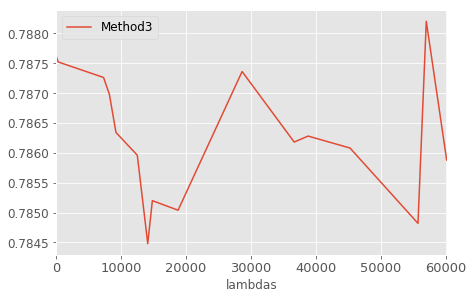

In [23]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

mean_acc_grouped_by_lmbda.plot(y='Method3')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.show()

### Some histograms

#### W_2

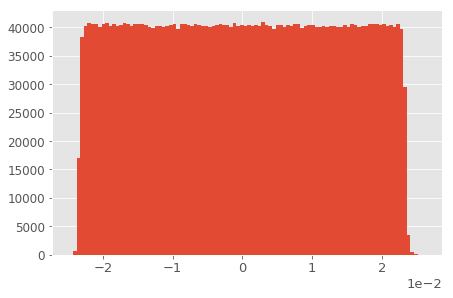

In [24]:
plt.hist(w_2.eval().flatten(), 100)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### Omega_W_2

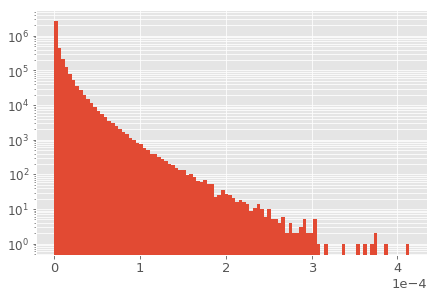

In [25]:
plt.hist(new_big_omeg_w2.flatten(),bins=100,log=True)
#plt.yscale('log')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### b_2

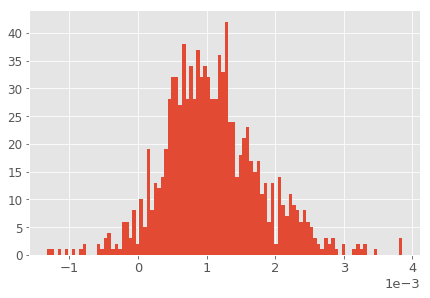

In [26]:
plt.hist(b_2.eval().flatten(), 100)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### Omega_b_2

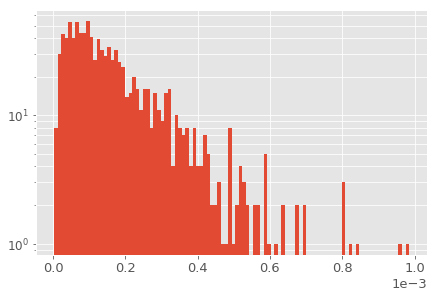

In [27]:
plt.hist(new_big_omeg_b2.flatten(),100,log=True)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### W_3

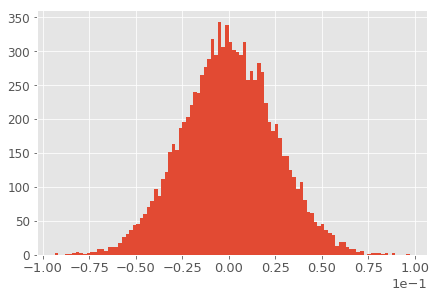

In [28]:
plt.hist(w_3.eval().flatten(), 100)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### b_3

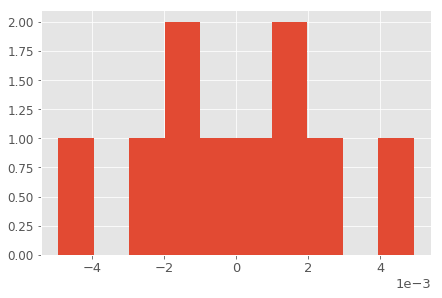

In [29]:
plt.hist(b_3.eval().flatten(), 10)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

### Init the writer with $\lambda$s (0, 6.75*2.5)e4

In [9]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_sh_16lmbdas_ar1_3lyrs_he1_v2', sess.graph)

### Generate $\lambda$s 

In [10]:
np.random.seed(100)
n_lmbdas = 15
a = np.random.uniform(low=0.0, high=6.75, size=(n_lmbdas,))
print(a)
print()
a = a*2.5e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[3.66798336 1.87899335 2.86549374 5.70223889 0.03185228 0.82059157
 4.52755632 5.5745061  0.92276948 3.88187997 6.01642319 1.41211432
 1.25096548 0.73154401 1.48295808]
()
[   796.30698223  18288.60026584  20514.78913215  23069.23700934
  31274.13704908  35302.85810728  37073.95188047  46974.83373458
  71637.34343892  91699.58392723  97046.99934085 113188.90804764
 139362.65242398 142555.97232898 150410.57979019]
()
([0, 796.3069822266202, 18288.600265843055, 20514.789132150523, 23069.237009335815, 31274.13704907517, 35302.858107275744, 37073.95188046742, 46974.833734578104, 71637.34343891621, 91699.58392722541, 97046.99934084844, 113188.9080476439, 139362.65242397678, 142555.97232898374, 150410.57979019455, 0, 796.3069822266202, 18288.600265843055, 20514.789132150523, 23069.237009335815, 31274.13704907517, 35302.858107275744, 37073.95188046742, 46974.833734578104, 71637.34343891621, 91699.58392722541, 97046.99934084844, 113188.9080476439, 139362.65242397678, 142555.97232898374, 150410

### Generate random weights

In [11]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(80, 80)


In [12]:
np.array_equal(np_weights[0], np_weights[15])

True

In [13]:
np.array_equal(np_weights[0], np_weights[16])

False

### Commence training

In [14]:
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()

Training with lmbda:0, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.9

Training on :(8, 9)
training cost:0.0535054244101 and training accuracy:0.985285878181
validation cost:0.0488348640501 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0479301735759 and training accuracy:0.986775934696
validation cost:0.0455383919179 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0442771986127 and training accuracy:0.987520933151
validation cost:0.0432717837393 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0408748500049 and training accuracy:0.988359093666
validation cost:0.0389142967761 and validation accuracy:0.993408679962
Training on :(8, 9)
Time taken:121.30377388
Method 3 test accuracy:0.78979998827
Training with lmbda:796.306982227, 1
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 

Training on :(8, 9)
training cost:0.15148922801 and training accuracy:0.965170443058
validation cost:0.148252308369 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.10349150002 and training accuracy:0.972527444363
validation cost:0.102656595409 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0822133123875 and training accuracy:0.975973188877
validation cost:0.0786989107728 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0692298561335 and training accuracy:0.979698240757
validation cost:0.0625535920262 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0596315972507 and training accuracy:0.983050823212
validation cost:0.0548168830574 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0535449199378 and training accuracy:0.985192775726
validation cost:0.0488376505673 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0478708669543 and traini

Training on :(6, 7)
training cost:0.00987485703081 and training accuracy:0.998917639256
validation cost:0.0103398412466 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00892970431596 and training accuracy:0.999098062515
validation cost:0.00891944114119 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:125.009098053
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153210803866 and training accuracy:0.964704811573
validation cost:0.146881058812 and validation accuracy:0.966101706028
Training on :(8, 9)
training cost:0.103699244559 and training accuracy:0.971875607967
validation cost:0.100957274437 and validation accuracy:0.976

Training on :(6, 7)
training cost:0.0241887103766 and training accuracy:0.997925519943
validation cost:0.0247597545385 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0189974773675 and training accuracy:0.997925519943
validation cost:0.0194135829806 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0156127111986 and training accuracy:0.998196065426
validation cost:0.0162430014461 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0131339710206 and training accuracy:0.998556852341
validation cost:0.0133459856734 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.011212753132 and training accuracy:0.9987372756
validation cost:0.011480296962 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00990417134017 and training accuracy:0.998917639256
validation cost:0.0102933067828 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00893883407116 and 

Training on :(4, 5)
Time taken:118.933258057
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0639220923185 and training accuracy:0.991431415081
validation cost:0.0631635710597 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0341743864119 and training accuracy:0.997294127941
validation cost:0.0343474708498 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0242358539253 and training accuracy:0.997925519943
validation cost:0.0247850101441 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0190198086202 and training accuracy:0.997925519943
validation cost:0.0194074325264 and validation accuracy:0.995

Training on :(4, 5)
training cost:0.0237225387245 and training accuracy:0.997853636742
validation cost:0.01825719513 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0200099293143 and training accuracy:0.998243927956
validation cost:0.0148150855675 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.01708384417 and training accuracy:0.998439013958
validation cost:0.0124439075589 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0154672898352 and training accuracy:0.998048782349
validation cost:0.0113083859906 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.014066869393 and training accuracy:0.998146355152
validation cost:0.0102049121633 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.247581959
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
tra

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0988501161337 and training accuracy:0.991609752178
validation cost:0.0914637222886 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0541028305888 and training accuracy:0.99287801981
validation cost:0.0477724932134 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0378667786717 and training accuracy:0.994731724262
validation cost:0.030252315104 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0291485805064 and training accuracy:0.99658536911
validation cost:0.0223447922617 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.023802658543 and training accuracy:0.997756123543
validation cost:0.0181183759123 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0200901124626 and training accuracy:0.998243927956
validation cost:0.014854083769 and vali

Training on :(2, 3)
training cost:0.0511706955731 and training accuracy:0.982910633087
validation cost:0.0508445911109 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0466096997261 and training accuracy:0.985728561878
validation cost:0.0470463596284 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.0426395870745 and training accuracy:0.987455666065
validation cost:0.041549731046 and validation accuracy:0.987132370472
Training on :(2, 3)
Time taken:122.146348953
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0989923924208 and training accuracy:0.991609752178
validation cost:0.0916132107377 and validation accuracy:0.997038483

Training on :(2, 3)
training cost:0.113399781287 and training accuracy:0.968548297882
validation cost:0.12098506093 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0886662453413 and training accuracy:0.97309333086
validation cost:0.0926548317075 and validation accuracy:0.967830896378
Training on :(2, 3)
training cost:0.0737865045667 and training accuracy:0.974275052547
validation cost:0.07908950001 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.064708955586 and training accuracy:0.977274775505
validation cost:0.0673271641135 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0565049946308 and training accuracy:0.9806381464
validation cost:0.0583447925746 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.051161698997 and training accuracy:0.982819736004
validation cost:0.0506649166346 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0465773865581 and training accura

Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.041059017
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.168318986893 and training accuracy:0.950004518032
validation cost:0.169079318643 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.11337454617 and training accuracy:0.968457400799
validation cost:0.12098506093 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0886882692575 and training accuracy:0.973184227943
validation cost:0.0922498106956 and validation accuracy:0.96875


Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997744202614
validation cost:0.00971961114556 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00863864738494 and training accuracy:0.998004496098
validation cost:0.0086479568854 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00776934204623 and training accuracy:0.99809128046
validation cost:0.0084388460964 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:127.957110882
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997

training cost:0.0486769229174 and training accuracy:0.986496567726
validation cost:0.0473077744246 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.045007288456 and training accuracy:0.987707197666
validation cost:0.0438957437873 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0415603145957 and training accuracy:0.988265991211
validation cost:0.040117777884 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.442662954
Method 3 test accuracy:0.781300008297
Training with lmbda:113188.908048, 12
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy

Training on :(8, 9)
training cost:0.103646531701 and training accuracy:0.972154974937
validation cost:0.0989990979433 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.082573890686 and training accuracy:0.975786924362
validation cost:0.0804234445095 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0689834356308 and training accuracy:0.979884505272
validation cost:0.0634634271264 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0603681579232 and training accuracy:0.982957720757
validation cost:0.056859780103 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0538872629404 and training accuracy:0.985006511211
validation cost:0.0515067912638 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0489155463874 and training accuracy:0.986310303211
validation cost:0.0471997708082 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0446824878454 and tr

Training on :(6, 7)
training cost:0.00918270554394 and training accuracy:0.999188244343
validation cost:0.00900432094932 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.155768871
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151894465089 and training accuracy:0.965263545513
validation cost:0.147132754326 and validation accuracy:0.966101706028
Training on :(8, 9)
training cost:0.10371812433 and training accuracy:0.972248077393
validation cost:0.101578719914 and validation accuracy:0.974576294422
Training on :(8, 9)
training cost:0.0822459459305 and training accuracy:0.976159453392
validation cost:0.0785198286176 and validation accuracy:0.98022

Training on :(6, 7)
training cost:0.0192371290177 and training accuracy:0.997925519943
validation cost:0.0195095110685 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0158599000424 and training accuracy:0.998286306858
validation cost:0.0162932816893 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.013314222917 and training accuracy:0.9987372756
validation cost:0.0137675013393 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0115742273629 and training accuracy:0.998647093773
validation cost:0.0122968517244 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0103127844632 and training accuracy:0.9987372756
validation cost:0.0100096752867 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00921260379255 and training accuracy:0.999188244343
validation cost:0.00924434978515 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.764304161
Current ma

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0636705160141 and training accuracy:0.991160809994
validation cost:0.0626512393355 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0343804769218 and training accuracy:0.997203946114
validation cost:0.0333191305399 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0243165139109 and training accuracy:0.997835278511
validation cost:0.0248917285353 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0192671623081 and training accuracy:0.997925519943
validation cost:0.0197508372366 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0158849991858 and training accuracy:0.998196065426
validation cost:0.0163610056043 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0133453505114 and training accuracy:0.9987372756
validation cos

training cost:0.0209832713008 and training accuracy:0.996975600719
validation cost:0.0149554889649 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0183575861156 and training accuracy:0.997365832329
validation cost:0.0124804545194 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0164001379162 and training accuracy:0.997560977936
validation cost:0.0110024530441 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149549171329 and training accuracy:0.997463405132
validation cost:0.0095500042662 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.277729988
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620987862349 and

Training on :(4, 5)
training cost:0.100175209343 and training accuracy:0.991414606571
validation cost:0.0899644941092 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0545722655952 and training accuracy:0.993073165417
validation cost:0.0472493432462 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.039478354156 and training accuracy:0.994731724262
validation cost:0.0319879502058 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0308999381959 and training accuracy:0.996292710304
validation cost:0.0236615557224 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0251184981316 and training accuracy:0.996292710304
validation cost:0.0193858724087 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0209882892668 and training accuracy:0.996975600719
validation cost:0.0149504188448 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0184116456658 and training ac

training cost:0.0520971044898 and training accuracy:0.985001385212
validation cost:0.0572928674519 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0473909676075 and training accuracy:0.986274003983
validation cost:0.052646279335 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.044321436435 and training accuracy:0.987455666065
validation cost:0.0489239394665 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:122.050449848
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0998949185014 and training accuracy:0.991414606571
validation cost:0.0898005142808 and validation accuracy:0.994077026844
Training on

Training on :(2, 3)
training cost:0.116115123034 and training accuracy:0.968820989132
validation cost:0.119510956109 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0903266966343 and training accuracy:0.974638640881
validation cost:0.0988492965698 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0756534710526 and training accuracy:0.977183878422
validation cost:0.0860961228609 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0662140473723 and training accuracy:0.979001879692
validation cost:0.0743382573128 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0593109801412 and training accuracy:0.982183456421
validation cost:0.0655158311129 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0523320250213 and training accuracy:0.984819591045
validation cost:0.0574324764311 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0474755242467 and 

Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:127.90159893
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172586724162 and training accuracy:0.948186516762
validation cost:0.175913929939 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116149775684 and training accuracy:0.968820989132
validation cost:0.119510956109 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0903266966343 and training accuracy:0.974638640881
validation cost:0.0988492965698 and validation accuracy:0.970588

Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.067500114
C

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 and training accuracy:0.99514144659
validation cost:0.0417454019189 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0227200146765 and training accuracy:0.994967877865
validation cost:0.0239276178181 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.99

Training on :(8, 9)
training cost:0.0495286546648 and training accuracy:0.985565304756
validation cost:0.046992868185 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0445526950061 and training accuracy:0.986869037151
validation cost:0.0443219691515 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0409540683031 and training accuracy:0.988359093666
validation cost:0.0409554950893 and validation accuracy:0.988700568676
Training on :(8, 9)
Time taken:120.033000946
Method 3 test accuracy:0.788399994373
Training with lmbda:37073.9518805, 23
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 

Training on :(8, 9)
training cost:0.105343349278 and training accuracy:0.968709230423
validation cost:0.102400757372 and validation accuracy:0.975517868996
Training on :(8, 9)
training cost:0.0842297524214 and training accuracy:0.974762499332
validation cost:0.0827304571867 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0706858709455 and training accuracy:0.979139506817
validation cost:0.0700647979975 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0616864226758 and training accuracy:0.982026457787
validation cost:0.0593126527965 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0551976636052 and training accuracy:0.984633982182
validation cost:0.0523497201502 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0495488718152 and training accuracy:0.985658407211
validation cost:0.0471847765148 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0448317304254 and t

training cost:0.0100257536396 and training accuracy:0.999098062515
validation cost:0.0100910728797 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00906832702458 and training accuracy:0.99927842617
validation cost:0.00897102989256 and validation accuracy:1.0
Training on :(6, 7)
Time taken:124.11333704
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.154370635748 and training accuracy:0.963121652603
validation cost:0.152970224619 and validation accuracy:0.961393594742
Training on :(8, 9)
training cost:0.105653375387 and training accuracy:0.968150496483
validation cost:0.102336391807 and validation accuracy:0.975517868996
Training on :(8, 9)
trai

Training on :(6, 7)
training cost:0.0241403542459 and training accuracy:0.998196065426
validation cost:0.0245787650347 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0186895895749 and training accuracy:0.998556852341
validation cost:0.0191698558629 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.015182456933 and training accuracy:0.998647093773
validation cost:0.0153837949038 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0129462461919 and training accuracy:0.998827457428
validation cost:0.013132693246 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0113100577146 and training accuracy:0.999007821083
validation cost:0.0112292328849 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0100640999153 and training accuracy:0.999007821083
validation cost:0.0102113625035 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00916577782482 and train

training cost:0.0153618594632 and training accuracy:0.997560977936
validation cost:0.00988249666989 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.904117107
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620153732598 and training accuracy:0.992694139481
validation cost:0.0632757097483 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0342619046569 and training accuracy:0.997654914856
validation cost:0.0347629822791 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0241278298199 and training accuracy:0.998196065426
validation cost:0.0242598894984 and validation accuracy:0.9981752038
Training on :(6, 7)
t

Training on :(4, 5)
training cost:0.0312403179705 and training accuracy:0.995999991894
validation cost:0.0240799617022 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.025688033551 and training accuracy:0.996195137501
validation cost:0.0196163412184 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0212961621583 and training accuracy:0.996975600719
validation cost:0.0153290098533 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0186645649374 and training accuracy:0.997365832329
validation cost:0.0129150385037 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0169854350388 and training accuracy:0.997365832329
validation cost:0.0115953329951 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0155731095001 and training accuracy:0.997560977936
validation cost:0.00991668738425 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.682409048
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test f

Time taken:122.939203978
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.100015625358 and training accuracy:0.991707324982
validation cost:0.0894328355789 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0547274723649 and training accuracy:0.993073165417
validation cost:0.0474314503372 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0396656058729 and training accuracy:0.994829297066
validation cost:0.0323840938509 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0312842652202 and training accuracy:0.995999991894
validation cost:0.0241411346942 and validation accuracy:0.998025655746
Training o

Training on :(2, 3)
training cost:0.0663103535771 and training accuracy:0.978820085526
validation cost:0.0739766508341 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0593317300081 and training accuracy:0.982274353504
validation cost:0.0660292580724 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0522460564971 and training accuracy:0.985001385212
validation cost:0.0573969744146 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0474216938019 and training accuracy:0.986001253128
validation cost:0.0527887903154 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.044284965843 and training accuracy:0.987364768982
validation cost:0.0486155338585 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:122.889750004
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid fea

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172764718533 and training accuracy:0.948186516762
validation cost:0.17598554492 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116086192429 and training accuracy:0.968820989132
validation cost:0.11926035583 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.090460985899 and training accuracy:0.974729597569
validation cost:0.0988436564803 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0754369422793 and training accuracy:0.977456569672
validation cost:0.0859469398856 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0662959218025 and training accuracy:0.978820085526
validation cost:0.0739766508341 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0592784844339 and training accuracy:0.982365250587
validation cost:0.

Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.558676958
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172764718533 and training accuracy:0.948186516762
validation cost:0.17598554492 and validation accuracy:0.

Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.997917771339
validation cost:0.013716164045 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 a

Training on :(8, 9)
training cost:0.0412655323744 and training accuracy:0.988359093666
validation cost:0.039038259536 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.560086966
Method 3 test accuracy:0.787899971008
Training with lmbda:796.306982227, 33
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 

Training on :(8, 9)
training cost:0.0701109468937 and training accuracy:0.978860139847
validation cost:0.0689178258181 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0606927275658 and training accuracy:0.982119560242
validation cost:0.0599196068943 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0538761503994 and training accuracy:0.984075248241
validation cost:0.0517532490194 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.04885622859 and training accuracy:0.985937774181
validation cost:0.0474339574575 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0442818291485 and training accuracy:0.987334728241
validation cost:0.042396042496 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0413575209677 and training accuracy:0.988452196121
validation cost:0.03872166574 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.894782066
Method 3 tes

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150328353047 and training accuracy:0.963401019573
validation cost:0.149026587605 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.102701582015 and training accuracy:0.971968710423
validation cost:0.102597594261 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0835989937186 and training accuracy:0.975414395332
validation cost:0.0832036808133 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.069928124547 and training accuracy:0.978953242302
validation cost:0.0685425326228 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0608660578728 and training accuracy:0.982119560242
validation cost:0.0590065866709 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0541558265686 and training accuracy:0.984261512756
validation cost:

Training on :(6, 7)
training cost:0.0109498500824 and training accuracy:0.998917639256
validation cost:0.0109585830942 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.009825469926 and training accuracy:0.999098062515
validation cost:0.0100832665339 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00868981331587 and training accuracy:0.999098062515
validation cost:0.00882900413126 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.530742884
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.15034994483 and training accuracy:0.963307857513
validation cost:0.149088099599 and validation accuracy:0.964218

Training on :(6, 7)
training cost:0.0337922163308 and training accuracy:0.997113764286
validation cost:0.0350391454995 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0234892256558 and training accuracy:0.998196065426
validation cost:0.0243732053787 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0182705931365 and training accuracy:0.998376488686
validation cost:0.0187453180552 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0148179456592 and training accuracy:0.998376488686
validation cost:0.0143084032461 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0127161117271 and training accuracy:0.998466670513
validation cost:0.0129405399784 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0109650548548 and training accuracy:0.998917639256
validation cost:0.011015413329 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00981589127332 and 

training cost:0.0158166438341 and training accuracy:0.998341441154
validation cost:0.0125233670697 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0143256597221 and training accuracy:0.998439013958
validation cost:0.0115584107116 and validation accuracy:1.0
Training on :(4, 5)
Time taken:117.263464212
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0619447119534 and training accuracy:0.991972565651
validation cost:0.061029817909 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.0337712094188 and training accuracy:0.997113764286
validation cost:0.0347214378417 and validation accuracy:0.997262775898
Training on :(6, 7)
training cos

Training on :(4, 5)
training cost:0.0378770381212 and training accuracy:0.995999991894
validation cost:0.0323400869966 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0287604443729 and training accuracy:0.997560977936
validation cost:0.0241905767471 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0236209537834 and training accuracy:0.997560977936
validation cost:0.0193193946034 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0200745668262 and training accuracy:0.997951209545
validation cost:0.0150113981217 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0174794290215 and training accuracy:0.998341441154
validation cost:0.0134059265256 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.015747917816 and training accuracy:0.998341441154
validation cost:0.0125230085105 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.01440339908 and training accuracy:0.998439013958
validation cost:0.0114608509466 an

Training on :(2, 3)
Time taken:123.313584805
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0965457856655 and training accuracy:0.993365824223
validation cost:0.0909845978022 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0525650121272 and training accuracy:0.994926810265
validation cost:0.046878118068 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0378543920815 and training accuracy:0.99590241909
validation cost:0.0321171209216 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0287195947021 and training accuracy:0.997658550739
validation cost:0.023715633899 and validation accuracy:1.0
Training on :(

Training on :(2, 3)
training cost:0.0620873831213 and training accuracy:0.979001879692
validation cost:0.0636912360787 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0548512041569 and training accuracy:0.981910765171
validation cost:0.0559078976512 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0495991893113 and training accuracy:0.984001457691
validation cost:0.0488325282931 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0459703207016 and training accuracy:0.984910488129
validation cost:0.0461137965322 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.0424869805574 and training accuracy:0.986728489399
validation cost:0.0427868589759 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:123.863579988
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160725980997 and training accuracy:0.955004096031
validation cost:0.161874428391 and validation accuracy:0.955882370472
Training on :(2, 3)
training cost:0.107107408345 and training accuracy:0.97127532959
validation cost:0.106736317277 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0833898261189 and training accuracy:0.975184082985
validation cost:0.0829503983259 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.070340141654 and training accuracy:0.977456569672
validation cost:0.071641638875 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0618648417294 and training accuracy:0.978910982609
validation cost:0.0633789896965 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0547424927354 and training accuracy:0.9817289114
validation cost:0.05

Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 and training accuracy:0.99809128046
validation cost:0.0103809628636 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00715233804658 and training accuracy:0.998178005219
validation cost:0.0096391858533 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:133.759968042
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160725980997 and training accuracy:0.955004096031
validation cost:0.161874428391 and validation accuracy:0.95

Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.997917771339
validation cost:0.013716164045 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 a

Training on :(8, 9)
training cost:0.0418532937765 and training accuracy:0.987986564636
validation cost:0.0401032157242 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:125.712031126
Method 3 test accuracy:0.787800014019
Training with lmbda:113188.908048, 44
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587

Training on :(8, 9)
training cost:0.0703809037805 and training accuracy:0.978580713272
validation cost:0.0701789557934 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0610729902983 and training accuracy:0.981840193272
validation cost:0.0586418285966 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0540510974824 and training accuracy:0.984261512756
validation cost:0.0523419864476 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0492127537727 and training accuracy:0.985565304756
validation cost:0.0477319508791 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0451922491193 and training accuracy:0.987148463726
validation cost:0.0431679934263 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0421819239855 and training accuracy:0.988265991211
validation cost:0.0403928495944 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:121.96715498
Method 3

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150566145778 and training accuracy:0.963959753513
validation cost:0.147449240088 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.103041596711 and training accuracy:0.972154974937
validation cost:0.101852245629 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0837976112962 and training accuracy:0.975693821907
validation cost:0.084143973887 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0703326538205 and training accuracy:0.978953242302
validation cost:0.070348136127 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0609009973705 and training accuracy:0.982119560242
validation cost:0.0593615882099 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0543972104788 and training accuracy:0.984075248241
validation cost:0.

Training on :(6, 7)
training cost:0.0113500533625 and training accuracy:0.9987372756
validation cost:0.011773891747 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0100625501946 and training accuracy:0.999007821083
validation cost:0.0102174188942 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00898596271873 and training accuracy:0.999098062515
validation cost:0.00927357468754 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:138.123650074
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150477424264 and training accuracy:0.964052915573
validation cost:0.14734838903 and validation accuracy:0.965160

Training on :(6, 7)
training cost:0.0339030586183 and training accuracy:0.997023522854
validation cost:0.0354124493897 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0235441979021 and training accuracy:0.998196065426
validation cost:0.0248404797167 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0184035394341 and training accuracy:0.998466670513
validation cost:0.0187263078988 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0151650840417 and training accuracy:0.998286306858
validation cost:0.0144225591794 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0129250707105 and training accuracy:0.998466670513
validation cost:0.013014617376 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0113065382466 and training accuracy:0.998827457428
validation cost:0.0115228723735 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0100046144798 and t

Training on :(4, 5)
training cost:0.0152014484629 and training accuracy:0.997463405132
validation cost:0.0111647546291 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:123.475393057
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680197104812 and training accuracy:0.990258872509
validation cost:0.0667800009251 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364416614175 and training accuracy:0.996392190456
validation cost:0.0359052494168 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0257732402533 and training accuracy:0.997384309769
validation cost:0.0257938690484 and validation accuracy:0.998

Training on :(4, 5)
training cost:0.0293699502945 and training accuracy:0.996780514717
validation cost:0.0219656378031 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0244361609221 and training accuracy:0.997170746326
validation cost:0.0176994390786 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.021232817322 and training accuracy:0.997463405132
validation cost:0.0151018612087 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0188996363431 and training accuracy:0.997365832329
validation cost:0.0134841846302 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0169202014804 and training accuracy:0.997365832329
validation cost:0.0122478334233 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0152351073921 and training accuracy:0.997463405132
validation cost:0.0111174015328 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:130.014928818
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 

Time taken:132.51511097
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0953333675861 and training accuracy:0.991999983788
validation cost:0.0893254652619 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0530296899378 and training accuracy:0.992975592613
validation cost:0.0449967347085 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0374041311443 and training accuracy:0.995121955872
validation cost:0.0301220621914 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0295025184751 and training accuracy:0.996780514717
validation cost:0.0222062747926 and validation accuracy:1.0
Training on :(4, 5)
tr

Training on :(2, 3)
training cost:0.0609599351883 and training accuracy:0.97991091013
validation cost:0.0678018853068 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0536979325116 and training accuracy:0.982456147671
validation cost:0.0580634698272 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0491064824164 and training accuracy:0.984365046024
validation cost:0.0535753816366 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0452875494957 and training accuracy:0.985728561878
validation cost:0.049983587116 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0414678454399 and training accuracy:0.987182974815
validation cost:0.0458880364895 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:136.737923145
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid feat

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162123292685 and training accuracy:0.953822374344
validation cost:0.167495980859 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.108008190989 and training accuracy:0.97154802084
validation cost:0.109002113342 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0838111937046 and training accuracy:0.976365804672
validation cost:0.0886647701263 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0697535276413 and training accuracy:0.977638423443
validation cost:0.076756618917 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0610267557204 and training accuracy:0.979820013046
validation cost:0.0678147599101 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537648648024 and training accuracy:0.982365250587
validation cost:0.057695

Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 and training accuracy:0.99809128046
validation cost:0.0085003040731 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:139.278537989
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162194564939 and training accuracy:0.953822374344
validation cost:0.167495980859 and validation accuracy:0.9

Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 and training accuracy:0.996616363525
validation cost:0.0185922384262 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0130954766646 and training accuracy:0.998004496098
validation cost:0.0150229362771 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998178005219
validation cost:0.0100549636409 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 

Training on :(8, 9)
training cost:0.0432544611394 and training accuracy:0.987241566181
validation cost:0.0409720055759 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:120.557790995
Method 3 test accuracy:0.791999995708
Training with lmbda:37073.9518805, 55
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062 and training accuracy:0.995228171349
validation cost:0.0439142361283 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 a

Training on :(8, 9)
training cost:0.0721436738968 and training accuracy:0.978580713272
validation cost:0.0725622624159 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0629352480173 and training accuracy:0.982212722301
validation cost:0.0629731193185 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0562690608203 and training accuracy:0.984168350697
validation cost:0.0542284399271 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0510250031948 and training accuracy:0.985285878181
validation cost:0.049770437181 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0468839071691 and training accuracy:0.986775934696
validation cost:0.0440308526158 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0432444922626 and training accuracy:0.987334728241
validation cost:0.0409017018974 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:121.024463892
Method 3

Time taken:124.503499031
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.1506844908 and training accuracy:0.963587284088
validation cost:0.152643844485 and validation accuracy:0.957627117634
Training on :(8, 9)
training cost:0.104683674872 and training accuracy:0.972527444363
validation cost:0.10667797178 and validation accuracy:0.974576294422
Training on :(8, 9)
training cost:0.0847524255514 and training accuracy:0.974483132362
validation cost:0.0845388248563 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0726089403033 and training accuracy:0.978301346302
validation cost:0.0728739723563 and validation accuracy:0.979284346104
Training on :(8,

Training on :(6, 7)
training cost:0.0161369889975 and training accuracy:0.998105883598
validation cost:0.0153667367995 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.01376098115 and training accuracy:0.998376488686
validation cost:0.0137675851583 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0117801707238 and training accuracy:0.998466670513
validation cost:0.0121707813814 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0104270409793 and training accuracy:0.9987372756
validation cost:0.0110761951655 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00943758990616 and training accuracy:0.998827457428
validation cost:0.0097176535055 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:124.396088123
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid featu

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0679095610976 and training accuracy:0.990349054337
validation cost:0.0671228468418 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364759005606 and training accuracy:0.996572554111
validation cost:0.0354130156338 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0259361155331 and training accuracy:0.997384309769
validation cost:0.0258508399129 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0203720629215 and training accuracy:0.997745096684
validation cost:0.0197528153658 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0162928104401 and training accuracy:0.998196065426
validation cost:0.0156377442181 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0137077653781 and training accuracy:0.998556852341
validation cost:0.

Training on :(4, 5)
training cost:0.0190728046 and training accuracy:0.997463405132
validation cost:0.0135627649724 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0172889623791 and training accuracy:0.997365832329
validation cost:0.0127224428579 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0156135195866 and training accuracy:0.997463405132
validation cost:0.0113343438134 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:114.924355984
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0679037421942 and training accuracy:0.990349054337
validation cost:0.066652148962 and validation accuracy:0.98813867569
Train

Training on :(4, 5)
training cost:0.0530664660037 and training accuracy:0.992975592613
validation cost:0.0452119298279 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0376579016447 and training accuracy:0.994926810265
validation cost:0.0304805375636 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0297700427473 and training accuracy:0.996682941914
validation cost:0.0224348772317 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0248977914453 and training accuracy:0.996975600719
validation cost:0.0182179380208 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0215430185199 and training accuracy:0.997365832329
validation cost:0.0153085095808 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.01913391985 and training accuracy:0.997463405132
validation cost:0.0135194053873 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0172407794744 and training accuracy:0.997463405132
v

training cost:0.0453727655113 and training accuracy:0.985819458961
validation cost:0.0493628680706 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0416166111827 and training accuracy:0.987182974815
validation cost:0.0455468893051 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:123.971861124
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0951368734241 and training accuracy:0.992292702198
validation cost:0.0890568494797 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0531992428005 and training accuracy:0.993073165417
validation cost:0.0454778335989 and validation accuracy:0.99703848362
Training o

Training on :(2, 3)
training cost:0.0837813392282 and training accuracy:0.976365804672
validation cost:0.0886367931962 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0697070658207 and training accuracy:0.977820217609
validation cost:0.0767865255475 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0612129755318 and training accuracy:0.979729115963
validation cost:0.0678525865078 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0541788227856 and training accuracy:0.982456147671
validation cost:0.0580561943352 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0492084957659 and training accuracy:0.984365046024
validation cost:0.0528121180832 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.045342259109 and training accuracy:0.985728561878
validation cost:0.0499227270484 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0417047590017 and

Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:129.072037935
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162052035332 and training accuracy:0.953913271427
validation cost:0.167119041085 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.107976578176 and training accuracy:0.971457123756
validation cost:0.109001517296 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0837869867682 and training accuracy:0.976365804672
validation cost:0.0886367931962 and validation accuracy:0.970588207245

Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:129.637654066
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.9

training cost:0.0489239878953 and training accuracy:0.985844671726
validation cost:0.0491009689867 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0446518622339 and training accuracy:0.987800359726
validation cost:0.0445098057389 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0412660241127 and training accuracy:0.987893462181
validation cost:0.0416884683073 and validation accuracy:0.989642202854
Training on :(8, 9)
Time taken:120.667655945
Method 3 test accuracy:0.778800010681
Training with lmbda:18288.6002658, 66
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accura

training cost:0.102464877069 and training accuracy:0.972527444363
validation cost:0.101435407996 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0818576961756 and training accuracy:0.976159453392
validation cost:0.0820057541132 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0692378431559 and training accuracy:0.980815768242
validation cost:0.0682745799422 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0605737268925 and training accuracy:0.983423352242
validation cost:0.0603957250714 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0538464002311 and training accuracy:0.984540879726
validation cost:0.0515225790441 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0490732826293 and training accuracy:0.985937774181
validation cost:0.0490423962474 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0445888079703 and training accuracy:0.

Training on :(6, 7)
training cost:0.00949676521122 and training accuracy:0.9987372756
validation cost:0.00949280615896 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:124.087237835
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.15145984292 and training accuracy:0.966660439968
validation cost:0.149531170726 and validation accuracy:0.969868183136
Training on :(8, 9)
training cost:0.102716974914 and training accuracy:0.972434341908
validation cost:0.10159561038 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0817595422268 and training accuracy:0.976345717907
validation cost:0.081954240799 and validation accuracy:0.97928434610

Training on :(6, 7)
training cost:0.0195216648281 and training accuracy:0.997474491596
validation cost:0.0207214094698 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0157921295613 and training accuracy:0.997654914856
validation cost:0.0163069777191 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0135549381375 and training accuracy:0.997925519943
validation cost:0.0139531595632 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0117451073602 and training accuracy:0.998286306858
validation cost:0.0124514037743 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0105627039447 and training accuracy:0.998466670513
validation cost:0.0110487388447 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00947526283562 and training accuracy:0.998827457428
validation cost:0.00949730630964 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:124.484637022
Current

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0630078688264 and training accuracy:0.990800023079
validation cost:0.063481092453 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0347890630364 and training accuracy:0.996572554111
validation cost:0.0345656350255 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0246202666312 and training accuracy:0.997564733028
validation cost:0.0255778823048 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.019567783922 and training accuracy:0.997474491596
validation cost:0.0205930992961 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0157794635743 and training accuracy:0.997654914856
validation cost:0.0163267850876 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0135523732752 and training accuracy:0.998015701771
validation co

Training on :(4, 5)
training cost:0.0182696077973 and training accuracy:0.997463405132
validation cost:0.0121029745787 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0164332278073 and training accuracy:0.997365832329
validation cost:0.0104616163298 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149385510013 and training accuracy:0.997365832329
validation cost:0.00910290423781 and validation accuracy:1.0
Training on :(4, 5)
Time taken:115.807803154
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0629022791982 and training accuracy:0.990800023079
validation cost:0.0632882639766 and validation accuracy:0.989963531494
Training on :(6, 7)
t

Training on :(4, 5)
training cost:0.0534101910889 and training accuracy:0.993073165417
validation cost:0.0432459153235 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0375725924969 and training accuracy:0.994829297066
validation cost:0.0289089884609 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0288783609867 and training accuracy:0.996487796307
validation cost:0.0223869141191 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0241064094007 and training accuracy:0.996975600719
validation cost:0.0180345587432 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0207818448544 and training accuracy:0.997170746326
validation cost:0.0141663858667 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0182659272105 and training accuracy:0.997365832329
validation cost:0.0120902210474 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0164355654269 and training accuracy:0.997365832329
validation cost:0.01

Training on :(2, 3)
training cost:0.0444477126002 and training accuracy:0.986637592316
validation cost:0.0474953353405 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:123.436239958
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0943033322692 and training accuracy:0.993463397026
validation cost:0.0831386074424 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0533407591283 and training accuracy:0.993073165417
validation cost:0.0434813648462 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0375525727868 and training accuracy:0.994829297066
validation cost:0.0288701783866 and validation accuracy:1.0


Training on :(2, 3)
training cost:0.0762327834964 and training accuracy:0.974911391735
validation cost:0.0821544378996 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0651618093252 and training accuracy:0.979183733463
validation cost:0.0662399530411 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0577904731035 and training accuracy:0.9817289114
validation cost:0.0604366473854 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.052157856524 and training accuracy:0.984092354774
validation cost:0.0546396039426 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0475571900606 and training accuracy:0.985637664795
validation cost:0.0517562516034 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0444196946919 and training accuracy:0.986546695232
validation cost:0.0476039946079 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:125.076636076
Current mask:[1.

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171819314361 and training accuracy:0.947277545929
validation cost:0.173728704453 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.115092851222 and training accuracy:0.968457400799
validation cost:0.119560241699 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0912140011787 and training accuracy:0.972002565861
validation cost:0.0962703675032 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0760872066021 and training accuracy:0.974911391735
validation cost:0.0825015157461 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0652142316103 and training accuracy:0.979001879692
validation cost:0.0661919564009 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0578996427357 and training accuracy:0.981819808483
validation cost

Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:129.66072011
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171822085977 and training accuracy:0.947277545929
validation cost:0.173728704453 and validation accuracy:0.9

Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 

Training on :(8, 9)
training cost:0.0423647351563 and training accuracy:0.987800359726
validation cost:0.0413728281856 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:120.606106043
Method 3 test accuracy:0.777700006962
Training with lmbda:139362.652424, 77
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411

Training on :(8, 9)
training cost:0.0694067925215 and training accuracy:0.980443298817
validation cost:0.0687839090824 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0612138211727 and training accuracy:0.983050823212
validation cost:0.0598130859435 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.054078694433 and training accuracy:0.984633982182
validation cost:0.0508561991155 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.049388114363 and training accuracy:0.985472142696
validation cost:0.0475774556398 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0456482507288 and training accuracy:0.986869037151
validation cost:0.044007383287 and validation accuracy:0.992467045784
Training on :(8, 9)
training cost:0.0424977652729 and training accuracy:0.988079726696
validation cost:0.0420758984983 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:121.434592962
Method 3 te

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151932418346 and training accuracy:0.967405498028
validation cost:0.146447703242 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.103574849665 and training accuracy:0.971689343452
validation cost:0.102265201509 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0827428102493 and training accuracy:0.975786924362
validation cost:0.0838534832001 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0697462707758 and training accuracy:0.980443298817
validation cost:0.0692382231355 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0611874982715 and training accuracy:0.983050823212
validation cost:0.0598047412932 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0540835373104 and training accuracy:0.984633982182
validation cost:

Training on :(6, 7)
training cost:0.0121061690152 and training accuracy:0.998196065426
validation cost:0.0126896938309 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0108507405967 and training accuracy:0.998466670513
validation cost:0.0114799691364 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00980369281024 and training accuracy:0.9987372756
validation cost:0.00978200417012 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:124.747390032
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.152182772756 and training accuracy:0.967405498028
validation cost:0.14825540781 and validation accuracy:0.9726930

### Final accuracies

In [15]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('spike_sh_16lmbdas_ar1_3lyrs_he1_v2.csv')
final_test_acc

,Method3,lambdas
0,0.7898,0.000000
1,0.7900,796.306982
2,0.7824,18288.600266
3,0.7821,20514.789132
4,0.7814,23069.237009
5,0.7831,31274.137049
6,0.7831,35302.858107
7,0.7829,37073.951880
8,0.7823,46974.833735
9,0.7810,71637.343439


#### Groupby $\lambda$s

In [16]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
mean_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
display(mean_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.78762
796.306982,0.78738
18288.600266,0.78516
20514.789132,0.78470
23069.237009,0.78456
31274.137049,0.78618
35302.858107,0.78568
37073.951880,0.78656
46974.833735,0.78600


In [17]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
std_acc_grouped_by_lmbda = acc_grouped_by_lmbda.std()
display(std_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.005442
796.306982,0.004962
18288.600266,0.005121
20514.789132,0.004569
23069.237009,0.005023
31274.137049,0.005949
35302.858107,0.005188
37073.951880,0.006839
46974.833735,0.005437


In [18]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
max_acc_grouped_by_lmbda = acc_grouped_by_lmbda.max()
display(max_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.7927
796.306982,0.7912
18288.600266,0.7918
20514.789132,0.7900
23069.237009,0.7907
31274.137049,0.7925
35302.858107,0.7920
37073.951880,0.7971
46974.833735,0.7925


#### Plots

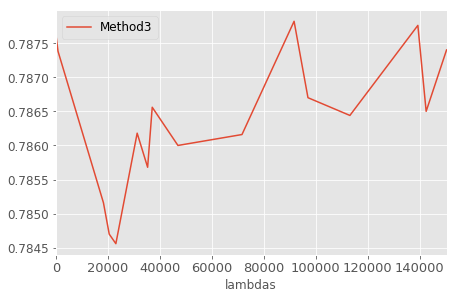

In [19]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

mean_acc_grouped_by_lmbda.plot(y='Method3')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.show()

### Init the $\lambda$s with (7.5, 10)

In [9]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_sh_15lmbdas_ar1_3lyrs_he1_75_10_no_exp', sess.graph)

### Generate $\lambda$s

In [10]:
np.random.seed(100)
n_lmbdas = 15
a = np.random.uniform(low=7.5, high=10, size=(n_lmbdas,))
print(a)
print()
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[8.85851235 8.19592346 8.56129398 9.61194033 7.51179714 7.8039228
 9.17687271 9.56463189 7.84176647 8.93773332 9.72830489 8.02300531
 7.96332055 7.77094223 8.04924373]
()
[7.51179714 7.77094223 7.8039228  7.84176647 7.96332055 8.02300531
 8.04924373 8.19592346 8.56129398 8.85851235 8.93773332 9.17687271
 9.56463189 9.61194033 9.72830489]
()
([0, 7.511797140477431, 7.770942226160638, 7.8039228019577855, 7.841766474212382, 7.9633205488751875, 8.023005305292974, 8.04924373156248, 8.195923462734491, 8.561293976872832, 8.858512354477414, 8.937733323568125, 9.176872711816946, 9.56463188776262, 9.61194033079976, 9.728304885780659, 0, 7.511797140477431, 7.770942226160638, 7.8039228019577855, 7.841766474212382, 7.9633205488751875, 8.023005305292974, 8.04924373156248, 8.195923462734491, 8.561293976872832, 8.858512354477414, 8.937733323568125, 9.176872711816946, 9.56463188776262, 9.61194033079976, 9.728304885780659, 0, 7.511797140477431, 7.770942226160638, 7.8039228019577855, 7.841766474212382, 7

### Generate random weights

In [11]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(80, 80)


In [12]:
np.array_equal(np_weights[0], np_weights[15])

True

In [13]:
np.array_equal(np_weights[0], np_weights[16])

False

### Commence training

In [14]:
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()

Training with lmbda:0, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.9

Training on :(8, 9)
training cost:0.0535054244101 and training accuracy:0.985285878181
validation cost:0.0488348640501 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0479301735759 and training accuracy:0.986775934696
validation cost:0.0455383919179 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0442771986127 and training accuracy:0.987520933151
validation cost:0.0432717837393 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0408748500049 and training accuracy:0.988359093666
validation cost:0.0389142967761 and validation accuracy:0.993408679962
Training on :(8, 9)
Time taken:119.170996189
Method 3 test accuracy:0.78979998827
Training with lmbda:7.51179714048, 1
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339

Training on :(8, 9)
training cost:0.151477068663 and training accuracy:0.965170443058
validation cost:0.148457437754 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.10356554389 and training accuracy:0.972527444363
validation cost:0.103338226676 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0823166370392 and training accuracy:0.975973188877
validation cost:0.0788178667426 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0693510770798 and training accuracy:0.979791402817
validation cost:0.0628246888518 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0596028491855 and training accuracy:0.983050823212
validation cost:0.0546582974494 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0535265989602 and training accuracy:0.985192775726
validation cost:0.0488242767751 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0480234026909 and trai

Training on :(6, 7)
training cost:0.00979856215417 and training accuracy:0.999007821083
validation cost:0.0101007102057 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0087788850069 and training accuracy:0.999098062515
validation cost:0.00852270238101 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.127705097
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151477068663 and training accuracy:0.965170443058
validation cost:0.148457437754 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.10356554389 and training accuracy:0.972527444363
validation cost:0.103338226676 and validation accuracy:0.97363

Training on :(6, 7)
training cost:0.0241673067212 and training accuracy:0.997745096684
validation cost:0.0247216559947 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0191191416234 and training accuracy:0.998015701771
validation cost:0.01931928657 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0155691420659 and training accuracy:0.998286306858
validation cost:0.0159959737211 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.012963745743 and training accuracy:0.9987372756
validation cost:0.013368149288 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.011112768203 and training accuracy:0.998827457428
validation cost:0.0117992609739 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00979856215417 and training accuracy:0.999007821083
validation cost:0.0101007102057 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0087788850069 and trai

Training on :(4, 5)
Time taken:114.125716925
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0636208951473 and training accuracy:0.991611778736
validation cost:0.0635736957192 and validation accuracy:0.989051103592
Training on :(6, 7)
training cost:0.0342947021127 and training accuracy:0.996843159199
validation cost:0.0337495431304 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0241673067212 and training accuracy:0.997745096684
validation cost:0.0247216559947 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0191191416234 and training accuracy:0.998015701771
validation cost:0.01931928657 and validation accuracy:0.9963

Training on :(4, 5)
training cost:0.023657489568 and training accuracy:0.997756123543
validation cost:0.0176057368517 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0198712404817 and training accuracy:0.998341441154
validation cost:0.0145276719704 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0169922467321 and training accuracy:0.998341441154
validation cost:0.0122214574367 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0153050273657 and training accuracy:0.998146355152
validation cost:0.011213125661 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0139560960233 and training accuracy:0.998243927956
validation cost:0.0100094126537 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.908252001
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0


training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0990518555045 and training accuracy:0.991609752178
validation cost:0.0925189256668 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0539999529719 and training accuracy:0.99287801981
validation cost:0.0477138087153 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0376890674233 and training accuracy:0.994829297066
validation cost:0.0302194636315 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0290481522679 and training accuracy:0.99658536911
validation cost:0.0220831781626 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.023657489568 and training accuracy:0.997756123543
validation cost:0.0176057368517 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0198712404817 and training accuracy:0.998341441154
validation cost:0.0145276719704 and va

Training on :(2, 3)
training cost:0.0513964854181 and training accuracy:0.982819736004
validation cost:0.0509350299835 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0464820750058 and training accuracy:0.985546767712
validation cost:0.0469166785479 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.0427470132709 and training accuracy:0.987273871899
validation cost:0.0414676591754 and validation accuracy:0.987132370472
Training on :(2, 3)
Time taken:122.589113951
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0990518555045 and training accuracy:0.991609752178
validation cost:0.0925189256668 and validation accuracy:0.99703848

Training on :(2, 3)
training cost:0.113371483982 and training accuracy:0.968548297882
validation cost:0.12098506093 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0885975807905 and training accuracy:0.97309333086
validation cost:0.0926486998796 and validation accuracy:0.967830896378
Training on :(2, 3)
training cost:0.0738820210099 and training accuracy:0.974093258381
validation cost:0.0787701904774 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0646886602044 and training accuracy:0.977183878422
validation cost:0.0672900676727 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0566079691052 and training accuracy:0.9806381464
validation cost:0.0583092048764 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0513964854181 and training accuracy:0.982819736004
validation cost:0.0509350299835 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0464820750058 and training ac

Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.211473942
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.168302044272 and training accuracy:0.950004518032
validation cost:0.169079318643 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.113371483982 and training accuracy:0.968548297882
validation cost:0.12098506093 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0885975807905 and training accuracy:0.97309333086
validation cost:0.0926486998796 and validation accuracy:0.967830

Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997744202614
validation cost:0.00971961114556 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00863864738494 and training accuracy:0.998004496098
validation cost:0.0086479568854 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00776934204623 and training accuracy:0.99809128046
validation cost:0.0084388460964 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:127.778723955
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997

training cost:0.0479701012373 and training accuracy:0.986682832241
validation cost:0.0454680249095 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.044334076345 and training accuracy:0.987334728241
validation cost:0.0435089208186 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0406236462295 and training accuracy:0.988545358181
validation cost:0.0390987917781 and validation accuracy:0.993408679962
Training on :(8, 9)
Time taken:119.857406855
Method 3 test accuracy:0.790000021458
Training with lmbda:9.17687271182, 12
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accurac

Training on :(8, 9)
training cost:0.103550389409 and training accuracy:0.972527444363
validation cost:0.103120595217 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0824230909348 and training accuracy:0.975973188877
validation cost:0.0788422375917 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0693369582295 and training accuracy:0.979791402817
validation cost:0.0627895593643 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0596635639668 and training accuracy:0.983050823212
validation cost:0.0547411032021 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0534497350454 and training accuracy:0.985285878181
validation cost:0.0488405413926 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0479923263192 and training accuracy:0.986682832241
validation cost:0.045550942421 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.04434235394 and trai

Training on :(6, 7)
training cost:0.0087788850069 and training accuracy:0.999098062515
validation cost:0.00852270238101 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.071674109
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151477068663 and training accuracy:0.965170443058
validation cost:0.148457437754 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.103550389409 and training accuracy:0.972527444363
validation cost:0.103120595217 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0824230909348 and training accuracy:0.975973188877
validation cost:0.0788422375917 and validation accuracy:0.98022

Training on :(6, 7)
training cost:0.0191191416234 and training accuracy:0.998015701771
validation cost:0.01931928657 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0155691420659 and training accuracy:0.998286306858
validation cost:0.0159959737211 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0129639329389 and training accuracy:0.9987372756
validation cost:0.0133697763085 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.011112768203 and training accuracy:0.998827457428
validation cost:0.0117992609739 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00979762617499 and training accuracy:0.999007821083
validation cost:0.0101021369919 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0087788850069 and training accuracy:0.999098062515
validation cost:0.00852270238101 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.371605873
Current ma

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0636208951473 and training accuracy:0.991611778736
validation cost:0.0635736957192 and validation accuracy:0.989051103592
Training on :(6, 7)
training cost:0.0342947021127 and training accuracy:0.996843159199
validation cost:0.0337495431304 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0241673067212 and training accuracy:0.997745096684
validation cost:0.0247216559947 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0191191416234 and training accuracy:0.998015701771
validation cost:0.01931928657 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0155691420659 and training accuracy:0.998286306858
validation cost:0.0159959737211 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0129639329389 and training accuracy:0.9987372756
validation cost

training cost:0.0209832713008 and training accuracy:0.996975600719
validation cost:0.0149554889649 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0183575861156 and training accuracy:0.997365832329
validation cost:0.0124804545194 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0164001379162 and training accuracy:0.997560977936
validation cost:0.0110024530441 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149549171329 and training accuracy:0.997463405132
validation cost:0.0095500042662 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.291078091
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620987862349 and

Training on :(4, 5)
training cost:0.0998727753758 and training accuracy:0.991609752178
validation cost:0.0896322578192 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0544792301953 and training accuracy:0.99317073822
validation cost:0.0472705699503 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.039569940418 and training accuracy:0.994829297066
validation cost:0.0322494134307 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0309216249734 and training accuracy:0.996292710304
validation cost:0.0237145852298 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0250762961805 and training accuracy:0.996390223503
validation cost:0.0194353610277 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0209832713008 and training accuracy:0.996975600719
validation cost:0.0149554889649 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0183576606214 and training ac

training cost:0.0523506365716 and training accuracy:0.984819591045
validation cost:0.0572108104825 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0472634024918 and training accuracy:0.986092150211
validation cost:0.0525288358331 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.044217325747 and training accuracy:0.987455666065
validation cost:0.0485626012087 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:122.725975037
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0998727753758 and training accuracy:0.991609752178
validation cost:0.0896322578192 and validation accuracy:0.994077026844
Training o

Training on :(2, 3)
training cost:0.116030067205 and training accuracy:0.96891194582
validation cost:0.119507059455 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0902791470289 and training accuracy:0.974820494652
validation cost:0.0988100841641 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0757050067186 and training accuracy:0.977274775505
validation cost:0.0859948545694 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0663870871067 and training accuracy:0.979001879692
validation cost:0.0742923021317 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0591977611184 and training accuracy:0.982274353504
validation cost:0.0650026425719 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0523506365716 and training accuracy:0.984819591045
validation cost:0.0572108104825 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0472634024918 and t

training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.111252069
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172586724162 and training accuracy:0.948186516762
validation cost:0.175913929939 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116030067205 and training accuracy:0.96891194582
validation cost:0.119507059455 and validation accuracy:0.964154422283
Training on

Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155

Training on :(8, 9)
Time taken:119.381731033
Method 3 test accuracy:0.791100025177
Training with lmbda:8.02300530529, 22
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 and training accuracy:0.99514144659
validation cost:0.0417454019189 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0227200146765 and training accuracy:0.994967877865
validation cost:0.0239276178181 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 

Training on :(8, 9)
training cost:0.0617894046009 and training accuracy:0.982026457787
validation cost:0.0594418868423 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0555416159332 and training accuracy:0.984075248241
validation cost:0.053346734494 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0496400222182 and training accuracy:0.985844671726
validation cost:0.0472700074315 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0445803552866 and training accuracy:0.987055301666
validation cost:0.0442854613066 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0405430085957 and training accuracy:0.988172829151
validation cost:0.040343914181 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:120.076274157
Method 3 test accuracy:0.791100025177
Training with lmbda:8.04924373156, 23
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labe

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153984576464 and training accuracy:0.962749123573
validation cost:0.153692275286 and validation accuracy:0.95951038599
Training on :(8, 9)
training cost:0.104996949434 and training accuracy:0.968429863453
validation cost:0.101843871176 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0838682577014 and training accuracy:0.975228190422
validation cost:0.0828503072262 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0702543258667 and training accuracy:0.979605138302
validation cost:0.0693361237645 and validation accuracy:0.98116761446
Training on :(8, 9)
training cost:0.0617894046009 and training accuracy:0.982026457787
validation cost:0.0594418868423 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0555416159332 and training accuracy:0.984075248241
validation cost:0.

Training on :(6, 7)
training cost:0.0110732596368 and training accuracy:0.999007821083
validation cost:0.0108604701236 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00984354596585 and training accuracy:0.999188244343
validation cost:0.0102103631943 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00882442854345 and training accuracy:0.999368607998
validation cost:0.00872092228383 and validation accuracy:1.0
Training on :(6, 7)
Time taken:123.484806061
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153984576464 and training accuracy:0.962749123573
validation cost:0.153692275286 and validation accuracy:0.95951038599


Training on :(6, 7)
training cost:0.0341977700591 and training accuracy:0.997564733028
validation cost:0.034630741924 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0241072438657 and training accuracy:0.998105883598
validation cost:0.0242516770959 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0183131210506 and training accuracy:0.998556852341
validation cost:0.0184767190367 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0150533709675 and training accuracy:0.998647093773
validation cost:0.0150910522789 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0126965390518 and training accuracy:0.998827457428
validation cost:0.0126975839958 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0110732596368 and training accuracy:0.999007821083
validation cost:0.0108604701236 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00984354596585 and trai

Training on :(4, 5)
training cost:0.016401251778 and training accuracy:0.997560977936
validation cost:0.0110024530441 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149549171329 and training accuracy:0.997463405132
validation cost:0.0095500042662 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.985738039
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620987862349 and training accuracy:0.992784321308
validation cost:0.0630205348134 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0341977700591 and training accuracy:0.997564733028
validation cost:0.034630741924 and validation accuracy:0.999087572098
Training on :

Training on :(4, 5)
training cost:0.039569940418 and training accuracy:0.994829297066
validation cost:0.0322494134307 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0309216249734 and training accuracy:0.996292710304
validation cost:0.0237145852298 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0250762961805 and training accuracy:0.996390223503
validation cost:0.0194353610277 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0209832713008 and training accuracy:0.996975600719
validation cost:0.0149554889649 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0183576606214 and training accuracy:0.997365832329
validation cost:0.0124804545194 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.016401251778 and training accuracy:0.997560977936
validation cost:0.0110024530441 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149549171329 and training accuracy:0.997463405132


training cost:0.044217325747 and training accuracy:0.987455666065
validation cost:0.0485626012087 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:122.891077042
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0998727753758 and training accuracy:0.991609752178
validation cost:0.0896322578192 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0544792301953 and training accuracy:0.99317073822
validation cost:0.0472705699503 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.039569940418 and training accuracy:0.994829297066
validation cost:0.0322494134307 and validation accuracy:0.998025655746
Training on 

Training on :(2, 3)
training cost:0.0757050067186 and training accuracy:0.977274775505
validation cost:0.0859948545694 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0663870871067 and training accuracy:0.979001879692
validation cost:0.0742923021317 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0591977611184 and training accuracy:0.982274353504
validation cost:0.0650026425719 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0523506365716 and training accuracy:0.984819591045
validation cost:0.0572108104825 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0472634024918 and training accuracy:0.986092150211
validation cost:0.0525288358331 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.044217325747 and training accuracy:0.987455666065
validation cost:0.0485626012087 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:122.547838211
Current 

Time taken:128.975996971
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172586724162 and training accuracy:0.948186516762
validation cost:0.175913929939 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116030067205 and training accuracy:0.96891194582
validation cost:0.119507059455 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0902791470289 and training accuracy:0.974820494652
validation cost:0.0988100841641 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0757050067186 and training accuracy:0.977274775505
validation cost:0.0859948545694 and validation accuracy:0.970588207245
Training on :(

Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:127.598098993
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Va

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.99

Training on :(8, 9)
training cost:0.0485742762685 and training accuracy:0.986030936241
validation cost:0.0470215454698 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0444778949022 and training accuracy:0.987148463726
validation cost:0.0425119064748 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0412655323744 and training accuracy:0.988359093666
validation cost:0.039038259536 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.611958027
Method 3 test accuracy:0.787899971008
Training with lmbda:7.51179714048, 33
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 

Training on :(8, 9)
training cost:0.102412380278 and training accuracy:0.972341239452
validation cost:0.101982183754 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.083344116807 and training accuracy:0.975507557392
validation cost:0.0832521691918 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.070045337081 and training accuracy:0.978860139847
validation cost:0.069665722549 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0608049072325 and training accuracy:0.982119560242
validation cost:0.0599401220679 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0541386380792 and training accuracy:0.983888983727
validation cost:0.0519279912114 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0487367026508 and training accuracy:0.985937774181
validation cost:0.0474847964942 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.044612005353 and train

Training on :(6, 7)
training cost:0.00865269917995 and training accuracy:0.999098062515
validation cost:0.00887368153781 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:122.796718121
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150610968471 and training accuracy:0.963307857513
validation cost:0.148379206657 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.102412380278 and training accuracy:0.972341239452
validation cost:0.101982183754 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.083344116807 and training accuracy:0.975507557392
validation cost:0.0832521691918 and validation accuracy:0.978342

Training on :(6, 7)
training cost:0.0181493237615 and training accuracy:0.998376488686
validation cost:0.0185021683574 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0148312756792 and training accuracy:0.998286306858
validation cost:0.0142422635108 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0126510653645 and training accuracy:0.998556852341
validation cost:0.0129125146195 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0109536452219 and training accuracy:0.998917639256
validation cost:0.0109229553491 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00972957536578 and training accuracy:0.999098062515
validation cost:0.00991043355316 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00865269917995 and training accuracy:0.999098062515
validation cost:0.00887368153781 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.093369961
Curre

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620246343315 and training accuracy:0.991882383823
validation cost:0.0611299872398 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.0337876565754 and training accuracy:0.997113764286
validation cost:0.0352338179946 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0235168673098 and training accuracy:0.998196065426
validation cost:0.0245644841343 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0181493237615 and training accuracy:0.998376488686
validation cost:0.0185021683574 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0148312756792 and training accuracy:0.998286306858
validation cost:0.0142422635108 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0126510653645 and training accuracy:0.998556852341
validation 

Training on :(4, 5)
training cost:0.0175067875534 and training accuracy:0.998243927956
validation cost:0.0135256079957 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0156422480941 and training accuracy:0.998439013958
validation cost:0.0123962080106 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0141632631421 and training accuracy:0.998536586761
validation cost:0.0110972858965 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.523622036
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620246343315 and training accuracy:0.991882383823
validation cost:0.0611299872398 and validation accuracy:0.991788327694
Training on :(6, 7)
tr

Training on :(4, 5)
training cost:0.0524932183325 and training accuracy:0.994926810265
validation cost:0.0472323782742 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0378093980253 and training accuracy:0.995999991894
validation cost:0.0320501588285 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0286116525531 and training accuracy:0.997658550739
validation cost:0.0240544546396 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0234345532954 and training accuracy:0.997658550739
validation cost:0.0190184507519 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0199774652719 and training accuracy:0.997951209545
validation cost:0.0152729824185 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0175067875534 and training accuracy:0.998243927956
validation cost:0.0135256079957 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0156422480941 and training accuracy:0.998439013958
validation cost:0.01

Training on :(2, 3)
training cost:0.0426699481905 and training accuracy:0.986819386482
validation cost:0.0424819812179 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:122.899775982
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0964237600565 and training accuracy:0.993365824223
validation cost:0.0909076109529 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0524932183325 and training accuracy:0.994926810265
validation cost:0.0472323782742 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0378093980253 and training accuracy:0.995999991894
validation cost:0.0320501588285 and validation accuracy:1.0


Training on :(2, 3)
training cost:0.0705194324255 and training accuracy:0.977365672588
validation cost:0.0716695934534 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.061932425946 and training accuracy:0.979183733463
validation cost:0.0637629032135 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0548364333808 and training accuracy:0.981638014317
validation cost:0.05614490062 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0493555441499 and training accuracy:0.984092354774
validation cost:0.0478820502758 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0461981035769 and training accuracy:0.984728634357
validation cost:0.0463549382985 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0426699481905 and training accuracy:0.986819386482
validation cost:0.0424819812179 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:122.473402023
Current ma

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160525530577 and training accuracy:0.955185890198
validation cost:0.161406889558 and validation accuracy:0.956801474094
Training on :(2, 3)
training cost:0.107004679739 and training accuracy:0.97127532959
validation cost:0.10699351877 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0832488685846 and training accuracy:0.975184082985
validation cost:0.0828824862838 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0705194324255 and training accuracy:0.977365672588
validation cost:0.0716695934534 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.061932425946 and training accuracy:0.979183733463
validation cost:0.0637629032135 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0548364333808 and training accuracy:0.981638014317
validation cost:0.

Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 and training accuracy:0.99809128046
validation cost:0.0103809628636 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00715233804658 and training accuracy:0.998178005219
validation cost:0.0096391858533 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:127.717247009
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160525530577 and training accuracy:0.955185890198
validation cost:0.161406889558 and validation accuracy:0.95

Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.997917771339
validation cost:0.013716164045 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 a

Training on :(8, 9)
training cost:0.0411448441446 and training accuracy:0.988452196121
validation cost:0.0381055735052 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.699141979
Method 3 test accuracy:0.787699997425
Training with lmbda:9.17687271182, 44
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587

Training on :(8, 9)
training cost:0.0700597092509 and training accuracy:0.978860139847
validation cost:0.069665722549 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0608077719808 and training accuracy:0.982119560242
validation cost:0.0599384345114 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0542613118887 and training accuracy:0.983888983727
validation cost:0.0517489239573 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.048560667783 and training accuracy:0.986217200756
validation cost:0.046834975481 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0446154810488 and training accuracy:0.987148463726
validation cost:0.0423506684601 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0411448441446 and training accuracy:0.988452196121
validation cost:0.0381055735052 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.611461878
Method 3 t

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150610968471 and training accuracy:0.963307857513
validation cost:0.148379206657 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.10241535306 and training accuracy:0.972341239452
validation cost:0.101982183754 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.083344116807 and training accuracy:0.975507557392
validation cost:0.0832521691918 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0700597092509 and training accuracy:0.978860139847
validation cost:0.069665722549 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0608048774302 and training accuracy:0.982119560242
validation cost:0.0599384345114 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0542613118887 and training accuracy:0.983888983727
validation cost:0.05

Training on :(6, 7)
training cost:0.0109536452219 and training accuracy:0.998917639256
validation cost:0.0109229553491 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00972952414304 and training accuracy:0.999098062515
validation cost:0.00991043355316 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00865269917995 and training accuracy:0.999098062515
validation cost:0.00887368153781 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.300586939
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150610968471 and training accuracy:0.963307857513
validation cost:0.148379206657 and validation accuracy:0.96

Training on :(6, 7)
training cost:0.0337876565754 and training accuracy:0.997113764286
validation cost:0.0352338179946 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0235168673098 and training accuracy:0.998196065426
validation cost:0.0245644841343 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0181493237615 and training accuracy:0.998376488686
validation cost:0.0185021683574 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0148312756792 and training accuracy:0.998286306858
validation cost:0.0142422635108 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0126510653645 and training accuracy:0.998556852341
validation cost:0.0129125146195 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0109536452219 and training accuracy:0.998917639256
validation cost:0.0109229553491 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00972952414304 and

Training on :(4, 5)
training cost:0.0152014484629 and training accuracy:0.997463405132
validation cost:0.0111647546291 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:114.595708847
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680197104812 and training accuracy:0.990258872509
validation cost:0.0667800009251 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364416614175 and training accuracy:0.996392190456
validation cost:0.0359052494168 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0257732402533 and training accuracy:0.997384309769
validation cost:0.0257938690484 and validation accuracy:0.998

Training on :(4, 5)
training cost:0.0293257758021 and training accuracy:0.996878027916
validation cost:0.0220163315535 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0244343895465 and training accuracy:0.997170746326
validation cost:0.0177498534322 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0212642587721 and training accuracy:0.997365832329
validation cost:0.0151087632403 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0189753547311 and training accuracy:0.99726831913
validation cost:0.0134452367201 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0169570632279 and training accuracy:0.997365832329
validation cost:0.0123243164271 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0152016272768 and training accuracy:0.997463405132
validation cost:0.011166298762 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:114.667946815
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0

Time taken:122.277740955
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0949183702469 and training accuracy:0.992292702198
validation cost:0.0888345390558 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0529517568648 and training accuracy:0.993073165417
validation cost:0.0452022999525 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0374374240637 and training accuracy:0.995121955872
validation cost:0.0302437376231 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0293257758021 and training accuracy:0.996878027916
validation cost:0.0220163315535 and validation accuracy:1.0
Training on :(4, 5)
t

Training on :(2, 3)
training cost:0.0611479505897 and training accuracy:0.979820013046
validation cost:0.0684051588178 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537941642106 and training accuracy:0.982274353504
validation cost:0.0580648817122 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0490117408335 and training accuracy:0.984365046024
validation cost:0.053463332355 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0451766401529 and training accuracy:0.985910356045
validation cost:0.0491817295551 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0416168235242 and training accuracy:0.987092077732
validation cost:0.0461915321648 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:122.56014204
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162095218897 and training accuracy:0.953822374344
validation cost:0.167138546705 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.10808005929 and training accuracy:0.97154802084
validation cost:0.109002113342 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.08375941962 and training accuracy:0.976184010506
validation cost:0.0887798964977 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0695839524269 and training accuracy:0.977729320526
validation cost:0.076758056879 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0611479505897 and training accuracy:0.979820013046
validation cost:0.0684051588178 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537941642106 and training accuracy:0.982274353504
validation cost:0.058064881

Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 and training accuracy:0.99809128046
validation cost:0.0085003040731 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:128.2124331
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162095218897 and training accuracy:0.953822374344
validation cost:0.167138546705 and validation accuracy:0.948

Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 and training accuracy:0.996616363525
validation cost:0.0185922384262 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0130954766646 and training accuracy:0.998004496098
validation cost:0.0150229362771 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998178005219
validation cost:0.0100549636409 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 

Training on :(8, 9)
training cost:0.0428918749094 and training accuracy:0.987707197666
validation cost:0.039778880775 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.806101084
Method 3 test accuracy:0.789699971676
Training with lmbda:8.04924373156, 55
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062 and training accuracy:0.995228171349
validation cost:0.0439142361283 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 an

Training on :(8, 9)
training cost:0.0724739655852 and training accuracy:0.978394508362
validation cost:0.0729391798377 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0630634278059 and training accuracy:0.981933295727
validation cost:0.0623452700675 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.05650402233 and training accuracy:0.983795881271
validation cost:0.0555954128504 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0511424206197 and training accuracy:0.985379040241
validation cost:0.0489751845598 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0461676008999 and training accuracy:0.986775934696
validation cost:0.0431391187012 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0428918749094 and training accuracy:0.987707197666
validation cost:0.039778880775 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.605131865
Method 3 t

Time taken:123.076019049
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150381758809 and training accuracy:0.963494122028
validation cost:0.151181966066 and validation accuracy:0.95951038599
Training on :(8, 9)
training cost:0.104619555175 and training accuracy:0.971782445908
validation cost:0.105768769979 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0849401280284 and training accuracy:0.974669396877
validation cost:0.0851943641901 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0724739655852 and training accuracy:0.978394508362
validation cost:0.0729391798377 and validation accuracy:0.979284346104
Training on :(

Training on :(6, 7)
training cost:0.0160018336028 and training accuracy:0.998105883598
validation cost:0.0156132113189 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0134475007653 and training accuracy:0.998556852341
validation cost:0.0136681627482 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0115041341633 and training accuracy:0.998556852341
validation cost:0.011905121617 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0101087251678 and training accuracy:0.9987372756
validation cost:0.0104181431234 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0091879600659 and training accuracy:0.998827457428
validation cost:0.00931676849723 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.453930855
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid feat

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680224522948 and training accuracy:0.990258872509
validation cost:0.0668077021837 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364408902824 and training accuracy:0.996392190456
validation cost:0.0359052494168 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.025768969208 and training accuracy:0.997384309769
validation cost:0.0258081890643 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0200419928879 and training accuracy:0.997745096684
validation cost:0.0192664135247 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0160018336028 and training accuracy:0.998105883598
validation cost:0.0156132113189 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0134475007653 and training accuracy:0.998556852341
validation cost:0

Training on :(4, 5)
training cost:0.0189753547311 and training accuracy:0.99726831913
validation cost:0.0134452367201 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0169570632279 and training accuracy:0.997365832329
validation cost:0.0123243164271 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0152016272768 and training accuracy:0.997463405132
validation cost:0.011166298762 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:114.720539093
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680224522948 and training accuracy:0.990258872509
validation cost:0.0668077021837 and validation accuracy:0.9881

Training on :(4, 5)
training cost:0.0529517568648 and training accuracy:0.993073165417
validation cost:0.0452022999525 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0374374240637 and training accuracy:0.995121955872
validation cost:0.0302437376231 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0293257758021 and training accuracy:0.996878027916
validation cost:0.0220163315535 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0244343895465 and training accuracy:0.997170746326
validation cost:0.0177498534322 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0212642587721 and training accuracy:0.997365832329
validation cost:0.0151087632403 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0189753547311 and training accuracy:0.99726831913
validation cost:0.0134452367201 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0169570632279 and training accuracy:0.997365832329


training cost:0.0451766401529 and training accuracy:0.985910356045
validation cost:0.0491817295551 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0416168235242 and training accuracy:0.987092077732
validation cost:0.0461915321648 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:122.32374692
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0949183702469 and training accuracy:0.992292702198
validation cost:0.0888345390558 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0529517568648 and training accuracy:0.993073165417
validation cost:0.0452022999525 and validation accuracy:0.99703848362
Training on :(4, 

Training on :(2, 3)
training cost:0.08375941962 and training accuracy:0.976184010506
validation cost:0.0887798964977 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0695839524269 and training accuracy:0.977729320526
validation cost:0.076758056879 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0611479505897 and training accuracy:0.979820013046
validation cost:0.0684051588178 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537941642106 and training accuracy:0.982274353504
validation cost:0.0580648817122 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0490117408335 and training accuracy:0.984365046024
validation cost:0.053463332355 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0451766401529 and training accuracy:0.985910356045
validation cost:0.0491817295551 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0416168235242 and tr

training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:128.303184986
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162095218897 and training accuracy:0.953822374344
validation cost:0.167138546705 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.10808005929 and training accuracy:0.97154802084
validation cost:0.109002113342 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.08375941962 and training accuracy:0.976184010506
validation cost:0.0887798964977 and validation accuracy:0.970588207245
Training on :(2, 3)
tra

Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:128.550239086
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.9

training cost:0.0490582250059 and training accuracy:0.985751509666
validation cost:0.0490953698754 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0447843149304 and training accuracy:0.987800359726
validation cost:0.0450638979673 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0413732491434 and training accuracy:0.987800359726
validation cost:0.0411700382829 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:119.538972139
Method 3 test accuracy:0.778800010681
Training with lmbda:7.77094222616, 66
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accura

Training on :(8, 9)
training cost:0.102401316166 and training accuracy:0.972713708878
validation cost:0.101458370686 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0814551189542 and training accuracy:0.976438820362
validation cost:0.0819562450051 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0689082220197 and training accuracy:0.980722665787
validation cost:0.0689102709293 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0609489642084 and training accuracy:0.982771456242
validation cost:0.0598627887666 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0537236705422 and training accuracy:0.984633982182
validation cost:0.0510799326003 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0490582250059 and training accuracy:0.985751509666
validation cost:0.0490953698754 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0447844676673 and t

Training on :(6, 7)
training cost:0.00935703516006 and training accuracy:0.998827457428
validation cost:0.00940547138453 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:123.89474082
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151710405946 and training accuracy:0.966474175453
validation cost:0.14873893559 and validation accuracy:0.970809817314
Training on :(8, 9)
training cost:0.102401316166 and training accuracy:0.972713708878
validation cost:0.101458370686 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0814551189542 and training accuracy:0.976438820362
validation cost:0.0819562450051 and validation accuracy:0.97928434

Training on :(6, 7)
training cost:0.0194008480757 and training accuracy:0.997474491596
validation cost:0.0205389261246 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0156705435365 and training accuracy:0.997745096684
validation cost:0.0162374582142 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0135167920962 and training accuracy:0.997925519943
validation cost:0.0137619227171 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0116283893585 and training accuracy:0.998376488686
validation cost:0.0124588711187 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0104563068599 and training accuracy:0.998466670513
validation cost:0.0107550639659 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00935703516006 and training accuracy:0.998827457428
validation cost:0.00940547138453 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:123.222752094
Current

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0629686638713 and training accuracy:0.990709841251
validation cost:0.063085667789 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0347865857184 and training accuracy:0.996572554111
validation cost:0.0342171937227 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0245375912637 and training accuracy:0.997474491596
validation cost:0.0253121834248 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0194008480757 and training accuracy:0.997474491596
validation cost:0.0205389261246 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0156705435365 and training accuracy:0.997745096684
validation cost:0.0162374582142 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0135167920962 and training accuracy:0.997925519943
validation c

Training on :(4, 5)
training cost:0.0181834287941 and training accuracy:0.99726831913
validation cost:0.0119842672721 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0161860194057 and training accuracy:0.997463405132
validation cost:0.010232088156 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0147315105423 and training accuracy:0.997463405132
validation cost:0.0089998356998 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.32191205
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0629686638713 and training accuracy:0.990709841251
validation cost:0.063085667789 and validation accuracy:0.989963531494
Training on :(6, 7)
traini

Training on :(4, 5)
training cost:0.053331580013 and training accuracy:0.993073165417
validation cost:0.0433798357844 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0374968871474 and training accuracy:0.994829297066
validation cost:0.0288449414074 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0288092717528 and training accuracy:0.996390223503
validation cost:0.0221864599735 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0239357799292 and training accuracy:0.996975600719
validation cost:0.0179479662329 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0206256192178 and training accuracy:0.997170746326
validation cost:0.0143882324919 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0181834287941 and training accuracy:0.99726831913
validation cost:0.0119842672721 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0161860194057 and training accuracy:0.997463405132
validation cost:0.0102

Training on :(2, 3)
training cost:0.0443670004606 and training accuracy:0.986728489399
validation cost:0.0479844585061 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:122.918368101
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0943072885275 and training accuracy:0.993463397026
validation cost:0.083395473659 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.053331580013 and training accuracy:0.993073165417
validation cost:0.0433798357844 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0374968871474 and training accuracy:0.994829297066
validation cost:0.0288449414074 and validation accuracy:1.0
Tr

Training on :(2, 3)
training cost:0.0760460272431 and training accuracy:0.975184082985
validation cost:0.0819085538387 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0653025358915 and training accuracy:0.979456424713
validation cost:0.0665035769343 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0580889172852 and training accuracy:0.9817289114
validation cost:0.0606088973582 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0521769523621 and training accuracy:0.984092354774
validation cost:0.0547606013715 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0476460047066 and training accuracy:0.985728561878
validation cost:0.0518938750029 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0443670004606 and training accuracy:0.986728489399
validation cost:0.0479844585061 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:122.612001896
Current m

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171883046627 and training accuracy:0.947368443012
validation cost:0.173870489001 and validation accuracy:0.943933844566
Training on :(2, 3)
training cost:0.115301266313 and training accuracy:0.968275606632
validation cost:0.11939971894 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0913520008326 and training accuracy:0.971911668777
validation cost:0.096379943192 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0760460272431 and training accuracy:0.975184082985
validation cost:0.0819085538387 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0653025358915 and training accuracy:0.979456424713
validation cost:0.0665035769343 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0580889172852 and training accuracy:0.9817289114
validation cost:0.06060889

Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:128.242738962
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171883046627 and training accuracy:0.947368443012
validation cost:0.173870489001 and validation accuracy:0.

Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 

Training on :(8, 9)
training cost:0.0413905642927 and training accuracy:0.987800359726
validation cost:0.0411700382829 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:122.518285036
Method 3 test accuracy:0.778800010681
Training with lmbda:9.56463188776, 77
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411

Training on :(8, 9)
training cost:0.0689082965255 and training accuracy:0.980722665787
validation cost:0.0689102709293 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0609489642084 and training accuracy:0.982771456242
validation cost:0.0598627887666 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0537236705422 and training accuracy:0.984633982182
validation cost:0.0510799326003 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0490582250059 and training accuracy:0.985751509666
validation cost:0.0490953698754 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0447834059596 and training accuracy:0.987800359726
validation cost:0.0450638979673 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0413905642927 and training accuracy:0.987800359726
validation cost:0.0411700382829 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:127.847625017
Method 3

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151710405946 and training accuracy:0.966474175453
validation cost:0.14873893559 and validation accuracy:0.970809817314
Training on :(8, 9)
training cost:0.102404296398 and training accuracy:0.972713708878
validation cost:0.101458370686 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0814551189542 and training accuracy:0.976438820362
validation cost:0.0819562450051 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0689082965255 and training accuracy:0.980722665787
validation cost:0.0689102709293 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0609489642084 and training accuracy:0.982771456242
validation cost:0.0598627887666 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0537236705422 and training accuracy:0.984633982182
validation cost:0

Training on :(6, 7)
training cost:0.0116283893585 and training accuracy:0.998376488686
validation cost:0.0124588711187 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0104563068599 and training accuracy:0.998466670513
validation cost:0.0107550639659 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00935703516006 and training accuracy:0.998827457428
validation cost:0.00940547138453 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:128.826741934
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151710405946 and training accuracy:0.966474175453
validation cost:0.14873893559 and validation accuracy:0.97080

### Final accuracies

In [15]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('spike_sh_15lmbdas_ar1_3lyrs_he1_75_10_noexp.csv')
final_test_acc

,Method3,lambdas
0,0.7898,0.000000
1,0.7904,7.511797
2,0.7904,7.770942
3,0.7904,7.803923
4,0.7904,7.841766
5,0.7904,7.963321
6,0.7904,8.023005
7,0.7904,8.049244
8,0.7904,8.195923
9,0.7900,8.561294


#### Groupby $\lambda$s

In [16]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
mean_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
display(mean_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.78762
7.511797,0.78752
7.770942,0.78752
7.803923,0.78752
7.841766,0.78752
7.963321,0.78752
8.023005,0.78752
8.049244,0.78752
8.195923,0.78754


In [17]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
std_acc_grouped_by_lmbda = acc_grouped_by_lmbda.std()
display(std_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.005442
7.511797,0.005047
7.770942,0.005047
7.803923,0.005047
7.841766,0.005047
7.963321,0.005047
8.023005,0.005047
8.049244,0.005047
8.195923,0.005048


In [18]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
max_acc_grouped_by_lmbda = acc_grouped_by_lmbda.max()
display(max_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.7927
7.511797,0.7911
7.770942,0.7911
7.803923,0.7911
7.841766,0.7911
7.963321,0.7911
8.023005,0.7911
8.049244,0.7911
8.195923,0.7911


#### Plots

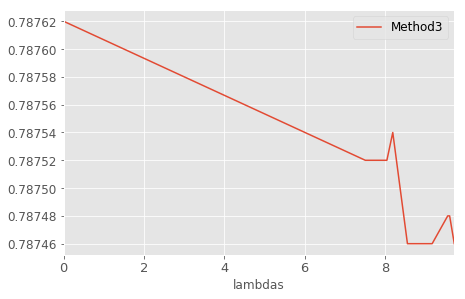

In [19]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

mean_acc_grouped_by_lmbda.plot(y='Method3')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.show()

### Init the writer with $\lambda$s with (7.5, 10)e4

In [9]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_sh_11lmbdas_ar1_3lyrs_he1_75_10', sess.graph)

### Generate $\lambda$s

In [10]:
np.random.seed(100)
n_lmbdas = 11
a = np.random.uniform(low=7.5, high=10.0, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[8.85851235 8.19592346 8.56129398 9.61194033 7.51179714 7.8039228
 9.17687271 9.56463189 7.84176647 8.93773332 9.72830489]
()
[75117.97140477 78039.22801958 78417.66474212 81959.23462734
 85612.93976873 88585.12354477 89377.33323568 91768.72711817
 95646.31887763 96119.403308   97283.04885781]
()
([0, 75117.9714047743, 78039.22801957786, 78417.66474212382, 81959.23462734491, 85612.93976872832, 88585.12354477413, 89377.33323568125, 91768.72711816947, 95646.3188776262, 96119.40330799759, 97283.04885780659, 0, 75117.9714047743, 78039.22801957786, 78417.66474212382, 81959.23462734491, 85612.93976872832, 88585.12354477413, 89377.33323568125, 91768.72711816947, 95646.3188776262, 96119.40330799759, 97283.04885780659, 0, 75117.9714047743, 78039.22801957786, 78417.66474212382, 81959.23462734491, 85612.93976872832, 88585.12354477413, 89377.33323568125, 91768.72711816947, 95646.3188776262, 96119.40330799759, 97283.04885780659, 0, 75117.9714047743, 78039.22801957786, 78417.66474212382, 81959.23462

### Generate random weights

In [11]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(60, 60)


In [13]:
np.array_equal(np_weights[0], np_weights[11])

True

In [14]:
np.array_equal(np_weights[0], np_weights[12])

False

### Commence training

In [15]:
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()

Training with lmbda:0, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.9

Training on :(8, 9)
training cost:0.0535054244101 and training accuracy:0.985285878181
validation cost:0.0488348640501 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0479301735759 and training accuracy:0.986775934696
validation cost:0.0455383919179 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0442771986127 and training accuracy:0.987520933151
validation cost:0.0432717837393 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0408748500049 and training accuracy:0.988359093666
validation cost:0.0389142967761 and validation accuracy:0.993408679962
Training on :(8, 9)
Time taken:119.011209965
Method 3 test accuracy:0.78979998827
Training with lmbda:75117.9714048, 1
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339

Training on :(8, 9)
training cost:0.153836905956 and training accuracy:0.964425384998
validation cost:0.149323090911 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.10382335633 and training accuracy:0.972061812878
validation cost:0.100419342518 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0825118497014 and training accuracy:0.975507557392
validation cost:0.0803260579705 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0690311715007 and training accuracy:0.979884505272
validation cost:0.063497364521 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0600628107786 and training accuracy:0.983330249786
validation cost:0.0547851137817 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0536887310445 and training accuracy:0.985192775726
validation cost:0.0500510074198 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0485435649753 and train

Training on :(6, 7)
training cost:0.0101387770846 and training accuracy:0.998917639256
validation cost:0.010450527072 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00904191937298 and training accuracy:0.999098062515
validation cost:0.00887104682624 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:122.692113876
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153822347522 and training accuracy:0.964518547058
validation cost:0.149019554257 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.103666186333 and training accuracy:0.972248077393
validation cost:0.100262284279 and validation accuracy:0.978342

Training on :(6, 7)
training cost:0.0242254137993 and training accuracy:0.997925519943
validation cost:0.0251228194684 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0190882645547 and training accuracy:0.998015701771
validation cost:0.0194757021964 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0156674105674 and training accuracy:0.998376488686
validation cost:0.0162552781403 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0131933540106 and training accuracy:0.9987372756
validation cost:0.0132505828515 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0114335697144 and training accuracy:0.998556852341
validation cost:0.0116607137024 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0101364161819 and training accuracy:0.998917639256
validation cost:0.010437913239 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00908243563026 and 

Training on :(4, 5)
Time taken:113.581077099
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0639065504074 and training accuracy:0.991160809994
validation cost:0.0631678625941 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0343281403184 and training accuracy:0.997203946114
validation cost:0.0342959165573 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0242078732699 and training accuracy:0.997925519943
validation cost:0.0248786602169 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.019029090181 and training accuracy:0.998105883598
validation cost:0.0191331338137 and validation accuracy:0.9963

Training on :(4, 5)
training cost:0.0238360613585 and training accuracy:0.997756123543
validation cost:0.0179852824658 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.020196646452 and training accuracy:0.998341441154
validation cost:0.0149767668918 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0173669699579 and training accuracy:0.998341441154
validation cost:0.0126678189263 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0157250855118 and training accuracy:0.998048782349
validation cost:0.0115619245917 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0142215723172 and training accuracy:0.998341441154
validation cost:0.0103907128796 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.889478922
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.098976187408 and training accuracy:0.991609752178
validation cost:0.0924149677157 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0541390888393 and training accuracy:0.992780506611
validation cost:0.0479610413313 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0379330180585 and training accuracy:0.994634151459
validation cost:0.0298050567508 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0293912421912 and training accuracy:0.996682941914
validation cost:0.0230122767389 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0238639675081 and training accuracy:0.997756123543
validation cost:0.0179974716157 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0202240161598 and training accuracy:0.998341441154
validation cost:0.0150300748646 and 

Training on :(2, 3)
training cost:0.0509592220187 and training accuracy:0.983183324337
validation cost:0.0507673285902 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0466038286686 and training accuracy:0.985546767712
validation cost:0.0466840267181 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.0428772233427 and training accuracy:0.987273871899
validation cost:0.0416418090463 and validation accuracy:0.987132370472
Training on :(2, 3)
Time taken:121.486817122
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0988612547517 and training accuracy:0.991609752178
validation cost:0.0913967117667 and validation accuracy:0.99703848

Training on :(2, 3)
training cost:0.113404043019 and training accuracy:0.968366503716
validation cost:0.120848722756 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0888367816806 and training accuracy:0.97309333086
validation cost:0.0928904414177 and validation accuracy:0.967830896378
Training on :(2, 3)
training cost:0.0739026740193 and training accuracy:0.974093258381
validation cost:0.0790253654122 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0647318512201 and training accuracy:0.977092981339
validation cost:0.0672434642911 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0565507002175 and training accuracy:0.980729043484
validation cost:0.0583482198417 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0509078428149 and training accuracy:0.982910633087
validation cost:0.050512842834 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0464681424201 and training 

Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.035738945
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.168385192752 and training accuracy:0.950004518032
validation cost:0.169110611081 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.113434426486 and training accuracy:0.968548297882
validation cost:0.12116727978 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0886235907674 and training accuracy:0.972911536694
validation cost:0.0931989625096 and validation accuracy:0.96783

Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997744202614
validation cost:0.00971961114556 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00863864738494 and training accuracy:0.998004496098
validation cost:0.0086479568854 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00776934204623 and training accuracy:0.99809128046
validation cost:0.0084388460964 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:127.443413973
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997

training cost:0.0486841313541 and training accuracy:0.986403405666
validation cost:0.0472118631005 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.044772259891 and training accuracy:0.987893462181
validation cost:0.04408133775 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0415276028216 and training accuracy:0.988359093666
validation cost:0.0401640608907 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.137481928
Method 3 test accuracy:0.780900001526
Training with lmbda:0, 12
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 and training accuracy:0.9951414465

Training on :(8, 9)
training cost:0.104966908693 and training accuracy:0.968429863453
validation cost:0.101662240922 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0838570669293 and training accuracy:0.975228190422
validation cost:0.0826450809836 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0704691037536 and training accuracy:0.979512035847
validation cost:0.0700912177563 and validation accuracy:0.98116761446
Training on :(8, 9)
training cost:0.0619770400226 and training accuracy:0.981747090816
validation cost:0.059368930757 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0556346476078 and training accuracy:0.984168350697
validation cost:0.0533436946571 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0496507994831 and training accuracy:0.985658407211
validation cost:0.0468872338533 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0448518916965 and tra

training cost:0.0100798970088 and training accuracy:0.999098062515
validation cost:0.0101417824626 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00914821494371 and training accuracy:0.99927842617
validation cost:0.00908604264259 and validation accuracy:1.0
Training on :(6, 7)
Time taken:123.114251137
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.15453068912 and training accuracy:0.963401019573
validation cost:0.152509748936 and validation accuracy:0.96233522892
Training on :(8, 9)
training cost:0.105428077281 and training accuracy:0.968709230423
validation cost:0.102065883577 and validation accuracy:0.975517868996
Training on :(8, 9)
train

Training on :(6, 7)
training cost:0.0241254400462 and training accuracy:0.998196065426
validation cost:0.0246706996113 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.018630662933 and training accuracy:0.998556852341
validation cost:0.0192007031292 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0151555901393 and training accuracy:0.998647093773
validation cost:0.0152837466449 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0130035411566 and training accuracy:0.998827457428
validation cost:0.0133294891566 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0113382926211 and training accuracy:0.999007821083
validation cost:0.0111597971991 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0101022142917 and training accuracy:0.999007821083
validation cost:0.0101169170812 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00918994564563 and trai

training cost:0.0154782123864 and training accuracy:0.997560977936
validation cost:0.0097478935495 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.446880102
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620010979474 and training accuracy:0.992694139481
validation cost:0.0629076212645 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0341748595238 and training accuracy:0.997835278511
validation cost:0.0348805896938 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0241136979312 and training accuracy:0.998196065426
validation cost:0.0244966819882 and validation accuracy:0.9981752038
Training on :(6, 7)
tr

Training on :(4, 5)
training cost:0.0311432536691 and training accuracy:0.996097564697
validation cost:0.0239992979914 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0254982933402 and training accuracy:0.996292710304
validation cost:0.0195289123803 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0212124753743 and training accuracy:0.997073173523
validation cost:0.0153550971299 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0186316072941 and training accuracy:0.99726831913
validation cost:0.012904974632 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0168396364897 and training accuracy:0.997463405132
validation cost:0.0112094143406 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.015247293748 and training accuracy:0.997560977936
validation cost:0.00982174742967 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.619308949
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test fea

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.100072264671 and training accuracy:0.991707324982
validation cost:0.0895595178008 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0546422563493 and training accuracy:0.993073165417
validation cost:0.0472769774497 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0395639874041 and training accuracy:0.994926810265
validation cost:0.0323345661163 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0310902222991 and training accuracy:0.996195137501
validation cost:0.0234501156956 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0254913717508 and training accuracy:0.996292710304
validation cost:0.0195671450347 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0213172920048 and training accuracy:0.997073173523
validation c

Training on :(2, 3)
training cost:0.0521844998002 and training accuracy:0.985092282295
validation cost:0.0573013313115 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0474345572293 and training accuracy:0.986092150211
validation cost:0.0528268925846 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.0444258674979 and training accuracy:0.987455666065
validation cost:0.0494688153267 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:121.710781813
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.100047759712 and training accuracy:0.991804897785
validation cost:0.0895595103502 and validation accuracy:0.995

Training on :(2, 3)
training cost:0.11614189297 and training accuracy:0.968639194965
validation cost:0.11943076551 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0903376936913 and training accuracy:0.974729597569
validation cost:0.0985019877553 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0756810083985 and training accuracy:0.977183878422
validation cost:0.0860212445259 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0661587491632 and training accuracy:0.978820085526
validation cost:0.0742029622197 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0591691359878 and training accuracy:0.982456147671
validation cost:0.0653409585357 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0520876608789 and training accuracy:0.985183179379
validation cost:0.0572772100568 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.047382067889 and tra

Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:127.819032907
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172660335898 and training accuracy:0.948277413845
validation cost:0.17598554492 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.11614189297 and training accuracy:0.968639194965
validation cost:0.11943076551 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0903359279037 and training accuracy:0.974729597569
validation cost:0.0984876006842 and validation accuracy:0.97150737

Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.103183031
C

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 and training accuracy:0.99514144659
validation cost:0.0417454019189 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0227200146765 and training accuracy:0.994967877865
validation cost:0.0239276178181 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.99

Training on :(8, 9)
training cost:0.0495459064841 and training accuracy:0.986124038696
validation cost:0.0472678132355 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0451401881874 and training accuracy:0.987055301666
validation cost:0.0436754375696 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0418114215136 and training accuracy:0.987986564636
validation cost:0.0411744751036 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:118.537163019
Method 3 test accuracy:0.794799983501
Training with lmbda:97283.0488578, 23
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622

Training on :(8, 9)
training cost:0.105352394283 and training accuracy:0.969174921513
validation cost:0.101996988058 and validation accuracy:0.975517868996
Training on :(8, 9)
training cost:0.0844190344214 and training accuracy:0.974669396877
validation cost:0.0812723189592 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0708524435759 and training accuracy:0.979418873787
validation cost:0.0702792555094 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0617915317416 and training accuracy:0.982398927212
validation cost:0.0587802752852 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0554417818785 and training accuracy:0.984540879726
validation cost:0.0526164509356 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.049585390836 and training accuracy:0.985844671726
validation cost:0.0472056753933 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0450709052384 and trai

Training on :(6, 7)
training cost:0.00864860136062 and training accuracy:0.999098062515
validation cost:0.00887368153781 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:122.410341024
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150494784117 and training accuracy:0.963401019573
validation cost:0.148497834802 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.102353192866 and training accuracy:0.972341239452
validation cost:0.101713344455 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.083420984447 and training accuracy:0.975693821907
validation cost:0.0832629576325 and validation accuracy:0.978342

Training on :(6, 7)
training cost:0.0183473136276 and training accuracy:0.998376488686
validation cost:0.0187788549811 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0149370962754 and training accuracy:0.998376488686
validation cost:0.0144498916343 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0128197111189 and training accuracy:0.998466670513
validation cost:0.0129445167258 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0112115265802 and training accuracy:0.998827457428
validation cost:0.0115833552554 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.00994374230504 and training accuracy:0.999007821083
validation cost:0.0101797971874 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00889002718031 and training accuracy:0.999098062515
validation cost:0.00902260933071 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:122.948436975
Curr

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0619778744876 and training accuracy:0.991882383823
validation cost:0.0614959336817 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.0337478853762 and training accuracy:0.997023522854
validation cost:0.0349341370165 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0234241336584 and training accuracy:0.998196065426
validation cost:0.0244643613696 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0184018071741 and training accuracy:0.998376488686
validation cost:0.0188780296594 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0149184986949 and training accuracy:0.998376488686
validation cost:0.0144067658111 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0128539893776 and training accuracy:0.998466670513
validation 

Training on :(4, 5)
training cost:0.0176348220557 and training accuracy:0.998243927956
validation cost:0.0132496263832 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.015848973766 and training accuracy:0.998341441154
validation cost:0.0122381318361 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0144896330312 and training accuracy:0.998439013958
validation cost:0.011537653394 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.379582882
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620821081102 and training accuracy:0.991702020168
validation cost:0.0611779987812 and validation accuracy:0.991788327694
Training on :(6, 7)
trai

Training on :(4, 5)
training cost:0.0527639091015 and training accuracy:0.994926810265
validation cost:0.0473769418895 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.038008350879 and training accuracy:0.995999991894
validation cost:0.0325503721833 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0289730876684 and training accuracy:0.997658550739
validation cost:0.0241014584899 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0237669162452 and training accuracy:0.997560977936
validation cost:0.0194174591452 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0200986564159 and training accuracy:0.998048782349
validation cost:0.0151099627838 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0176378116012 and training accuracy:0.998243927956
validation cost:0.013330694288 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0158957242966 and training accuracy:0.998341441154
validation cost:0.0124

Training on :(2, 3)
training cost:0.0424053296447 and training accuracy:0.986819386482
validation cost:0.0421728901565 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:121.552802086
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0966251343489 and training accuracy:0.993365824223
validation cost:0.0911082327366 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0528138689697 and training accuracy:0.994926810265
validation cost:0.0475090667605 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0379520654678 and training accuracy:0.996097564697
validation cost:0.0327371656895 and validation accuracy:1.0


Training on :(2, 3)
training cost:0.0704207867384 and training accuracy:0.977456569672
validation cost:0.0717972293496 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0620319917798 and training accuracy:0.979001879692
validation cost:0.063433110714 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0549093037844 and training accuracy:0.9817289114
validation cost:0.0560600496829 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0495077297091 and training accuracy:0.983819663525
validation cost:0.0482592582703 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0463174730539 and training accuracy:0.984819591045
validation cost:0.0462377034128 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0423813350499 and training accuracy:0.986910283566
validation cost:0.0420241989195 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:121.69587779
Current mas

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160725980997 and training accuracy:0.955004096031
validation cost:0.161874428391 and validation accuracy:0.955882370472
Training on :(2, 3)
training cost:0.107112951577 and training accuracy:0.971184432507
validation cost:0.106819964945 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0834360271692 and training accuracy:0.975184082985
validation cost:0.082379616797 and validation accuracy:0.973345577717
Training on :(2, 3)
training cost:0.0704340711236 and training accuracy:0.977638423443
validation cost:0.0716751888394 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0620285905898 and training accuracy:0.979183733463
validation cost:0.0635455548763 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.054847497493 and training accuracy:0.9817289114
validation cost:0.0

Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 and training accuracy:0.99809128046
validation cost:0.0103809628636 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00715233804658 and training accuracy:0.998178005219
validation cost:0.0096391858533 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:127.041901112
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160725980997 and training accuracy:0.955004096031
validation cost:0.161874428391 and validation accuracy:0.95

Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.997917771339
validation cost:0.013716164045 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 a

Training on :(8, 9)
training cost:0.0421020537615 and training accuracy:0.987986564636
validation cost:0.0403355322778 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.220602036
Method 3 test accuracy:0.787899971008
Training with lmbda:96119.403308, 34
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 

Training on :(8, 9)
training cost:0.0699770152569 and training accuracy:0.978487610817
validation cost:0.0692854598165 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0609461627901 and training accuracy:0.982026457787
validation cost:0.0585944391787 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0538924783468 and training accuracy:0.984168350697
validation cost:0.0521825365722 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0490600951016 and training accuracy:0.985658407211
validation cost:0.0474438033998 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0450747460127 and training accuracy:0.987334728241
validation cost:0.0429281331599 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0419042855501 and training accuracy:0.988079726696
validation cost:0.0402523465455 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:118.468575954
Method 

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150331676006 and training accuracy:0.964239180088
validation cost:0.147141233087 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.103209413588 and training accuracy:0.971968710423
validation cost:0.103051297367 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0837777480483 and training accuracy:0.975600659847
validation cost:0.085197404027 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0701616033912 and training accuracy:0.978673875332
validation cost:0.0694941878319 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.060812395066 and training accuracy:0.982212722301
validation cost:0.0583771318197 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0539480186999 and training accuracy:0.984168350697
validation cost:0.

Training on :(6, 7)
training cost:0.0115250283852 and training accuracy:0.998556852341
validation cost:0.0119702173397 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0101073002443 and training accuracy:0.9987372756
validation cost:0.0104008261114 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00918213743716 and training accuracy:0.998827457428
validation cost:0.00931342691183 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:137.529551029
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.1503149122 and training accuracy:0.963680386543
validation cost:0.150966629386 and validation accuracy:0.959510

Training on :(6, 7)
training cost:0.0365742444992 and training accuracy:0.996572554111
validation cost:0.0356234833598 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0259965881705 and training accuracy:0.997564733028
validation cost:0.0256560128182 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0202693659812 and training accuracy:0.997745096684
validation cost:0.0195685718209 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0162180028856 and training accuracy:0.998105883598
validation cost:0.0153207359836 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0137576460838 and training accuracy:0.998376488686
validation cost:0.0138219660148 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0117146475241 and training accuracy:0.998556852341
validation cost:0.0122512932867 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0104330694303 and tr

training cost:0.0171323660761 and training accuracy:0.997365832329
validation cost:0.0125984335318 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0154739692807 and training accuracy:0.997463405132
validation cost:0.0110949091613 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:122.026217937
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0679158046842 and training accuracy:0.990258872509
validation cost:0.066998116672 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364875346422 and training accuracy:0.996572554111
validation cost:0.0356640070677 and validation accuracy:0.9981752038
Training on :

Training on :(4, 5)
training cost:0.0376236438751 and training accuracy:0.994926810265
validation cost:0.0308784414083 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0294845663011 and training accuracy:0.996682941914
validation cost:0.022687677294 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0247660800815 and training accuracy:0.996975600719
validation cost:0.0181243792176 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0215961616486 and training accuracy:0.997365832329
validation cost:0.0153548251837 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0191075857729 and training accuracy:0.997463405132
validation cost:0.0135859195143 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.017243059352 and training accuracy:0.997365832329
validation cost:0.0126366894692 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0155066363513 and training accuracy:0.99

Training on :(2, 3)
training cost:0.0416738688946 and training accuracy:0.987001180649
validation cost:0.0461941063404 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:129.050164223
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0954852178693 and training accuracy:0.991999983788
validation cost:0.0895950272679 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0530428551137 and training accuracy:0.992975592613
validation cost:0.0452360101044 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0376278720796 and training accuracy:0.994926810265
validation cost:0.030565854162 and validation accuracy:0.9990

Training on :(2, 3)
training cost:0.0695600807667 and training accuracy:0.977729320526
validation cost:0.0767798423767 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0611925497651 and training accuracy:0.979729115963
validation cost:0.0683751478791 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0538575313985 and training accuracy:0.982456147671
validation cost:0.0581151917577 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0493303313851 and training accuracy:0.984274148941
validation cost:0.0528823435307 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0454167574644 and training accuracy:0.985728561878
validation cost:0.0491918027401 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0416537225246 and training accuracy:0.987273871899
validation cost:0.0463530868292 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:122.11205101
Current 

Training on :(0, 1)
Time taken:127.883944035
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162099152803 and training accuracy:0.953822374344
validation cost:0.167225301266 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.108113572001 and training accuracy:0.971457123756
validation cost:0.109079107642 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0838573127985 and training accuracy:0.975820362568
validation cost:0.0887906253338 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.069667764008 and training accuracy:0.977820217609
validation cost:0.0767827033997 and validation accuracy:0.970588207245
T

Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998178005219
validation cost:0.0100549636409 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 and training accuracy:0.99809128046
validation cost:0.0085003040731 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:127.921876907
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Vali

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062 and training accuracy:0.995228171349
validation cost:0.0439142361283 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 and training accuracy:0.996616363525
validation cost:0.0185922384262 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0130954766646 and training accuracy:0.998004496098
validation cost:0.0150229362771 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998

Training on :(8, 9)
training cost:0.0519897155464 and training accuracy:0.985379040241
validation cost:0.0500081479549 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0472787581384 and training accuracy:0.986682832241
validation cost:0.0455585382879 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0435055494308 and training accuracy:0.987148463726
validation cost:0.0410305820405 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.272642851
Method 3 test accuracy:0.797599971294
Training with lmbda:95646.3188776, 45
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062

Training on :(8, 9)
training cost:0.104868650436 and training accuracy:0.971968710423
validation cost:0.107577465475 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0852393060923 and training accuracy:0.973738133907
validation cost:0.0855125933886 and validation accuracy:0.975517868996
Training on :(8, 9)
training cost:0.0728708282113 and training accuracy:0.978394508362
validation cost:0.0724294111133 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0628271251917 and training accuracy:0.982212722301
validation cost:0.0633487999439 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0566391870379 and training accuracy:0.984075248241
validation cost:0.0546236559749 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0520124472678 and training accuracy:0.985472142696
validation cost:0.0503733642399 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0471248626709 and 

training cost:0.0104821519926 and training accuracy:0.9987372756
validation cost:0.0111053371802 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00949028600007 and training accuracy:0.998827457428
validation cost:0.00986072048545 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.158860922
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150855898857 and training accuracy:0.963401019573
validation cost:0.154398515821 and validation accuracy:0.957627117634
Training on :(8, 9)
training cost:0.104005746543 and training accuracy:0.972248077393
validation cost:0.105876930058 and validation accuracy:0.973634660244
Training on :

Training on :(6, 7)
training cost:0.0259700287133 and training accuracy:0.997384309769
validation cost:0.0257840957493 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0203153789043 and training accuracy:0.997745096684
validation cost:0.0197648666799 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0162978507578 and training accuracy:0.998196065426
validation cost:0.015631582588 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0137451030314 and training accuracy:0.998556852341
validation cost:0.0140545610338 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0117359617725 and training accuracy:0.998556852341
validation cost:0.0119873089716 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0104651032016 and training accuracy:0.9987372756
validation cost:0.011041617021 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00955755356699 and train

Training on :(4, 5)
Time taken:114.334095955
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0629686638713 and training accuracy:0.990709841251
validation cost:0.063085667789 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0347865857184 and training accuracy:0.996572554111
validation cost:0.0342171937227 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0245375912637 and training accuracy:0.997474491596
validation cost:0.0253121834248 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0194009188563 and training accuracy:0.997474491596
validation cost:0.0205389261246 and validation accuracy:0.995

Training on :(4, 5)
training cost:0.0241878777742 and training accuracy:0.997170746326
validation cost:0.0180740915239 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0209347400814 and training accuracy:0.997170746326
validation cost:0.014266253449 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0184335317463 and training accuracy:0.997463405132
validation cost:0.0123080359772 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0165394619107 and training accuracy:0.997365832329
validation cost:0.0106113450602 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0150879118592 and training accuracy:0.997463405132
validation cost:0.00938514713198 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.131256104
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0942446738482 and training accuracy:0.993463397026
validation cost:0.0833255201578 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0534818395972 and training accuracy:0.993073165417
validation cost:0.0437033511698 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0377921238542 and training accuracy:0.994829297066
validation cost:0.0294512026012 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0291069876403 and training accuracy:0.996390223503
validation cost:0.0224618222564 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0241432543844 and training accuracy:0.997073173523
validation cost:0.0180117469281 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0209344960749 and training accuracy:0.99726831913
validation cost:0.0142966872081 and validatio

Training on :(2, 3)
training cost:0.0521842092276 and training accuracy:0.983910560608
validation cost:0.0546438992023 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0477249547839 and training accuracy:0.985637664795
validation cost:0.0513819418848 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0442402586341 and training accuracy:0.986546695232
validation cost:0.0474807396531 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:121.756142139
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0944822877645 and training accuracy:0.993463397026
validation cost:0.0840704366565 and validation accuracy:0.99802565

Training on :(2, 3)
training cost:0.115122787654 and training accuracy:0.968366503716
validation cost:0.119388438761 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0912728235126 and training accuracy:0.971729815006
validation cost:0.0964259728789 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0760823339224 and training accuracy:0.975002288818
validation cost:0.0818870663643 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0652695819736 and training accuracy:0.979183733463
validation cost:0.0662479698658 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0578274950385 and training accuracy:0.981819808483
validation cost:0.0605131089687 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0523517765105 and training accuracy:0.984092354774
validation cost:0.0547119416296 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0477487668395 and trainin

Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:128.047772884
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171819314361 and training accuracy:0.947277545929
validation cost:0.173728704453 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.115139946342 and training accuracy:0.968366503716
validation cost:0.119561992586 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0913570523262 and training accuracy:0.971729815006
validation cost:0.0964259728789 and validation accuracy:0.9687

Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:127.461713076
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.9

training cost:0.0491452142596 and training accuracy:0.985937774181
validation cost:0.0472751818597 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0448446087539 and training accuracy:0.987800359726
validation cost:0.0436350107193 and validation accuracy:0.992467045784
Training on :(8, 9)
training cost:0.0424458682537 and training accuracy:0.988079726696
validation cost:0.0426973290741 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:119.23467207
Method 3 test accuracy:0.778299987316
Training with lmbda:91768.7271182, 56
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accurac

Training on :(8, 9)
training cost:0.103351868689 and training accuracy:0.971503078938
validation cost:0.101566515863 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0822013616562 and training accuracy:0.976066291332
validation cost:0.0817706361413 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0692570433021 and training accuracy:0.980536401272
validation cost:0.068793579936 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0611932165921 and training accuracy:0.982864618301
validation cost:0.0598175153136 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0539230331779 and training accuracy:0.984727144241
validation cost:0.0509490929544 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0489925183356 and training accuracy:0.986217200756
validation cost:0.0466404259205 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0450993292034 and t

Training on :(6, 7)
training cost:0.00964837148786 and training accuracy:0.998917639256
validation cost:0.00956209935248 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:122.729166031
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151790380478 and training accuracy:0.966939866543
validation cost:0.148056328297 and validation accuracy:0.971751391888
Training on :(8, 9)
training cost:0.103241428733 and training accuracy:0.971503078938
validation cost:0.10190666467 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0821164548397 and training accuracy:0.975786924362
validation cost:0.0813427641988 and validation accuracy:0.9792843

Training on :(6, 7)
training cost:0.0195995382965 and training accuracy:0.997384309769
validation cost:0.0206369291991 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0160359572619 and training accuracy:0.997654914856
validation cost:0.0169270075858 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0138023337349 and training accuracy:0.998015701771
validation cost:0.0141139831394 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0120247332379 and training accuracy:0.998196065426
validation cost:0.0127968331799 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0107433199883 and training accuracy:0.998466670513
validation cost:0.011371685192 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0096881724894 and training accuracy:0.998827457428
validation cost:0.00962863955647 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:123.12809515
Current ma

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0627911537886 and training accuracy:0.990980446339
validation cost:0.0634372830391 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0347861684859 and training accuracy:0.996662735939
validation cost:0.0346069782972 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0247806087136 and training accuracy:0.997654914856
validation cost:0.0256727673113 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0195884797722 and training accuracy:0.997384309769
validation cost:0.0206439364702 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.015999969095 and training accuracy:0.997654914856
validation cost:0.0165382213891 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0138052655384 and training accuracy:0.997925519943
validation c

### Final accuracies

In [16]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('spike_sh_11lmbdas_ar1_3lyrs_he1_75_10.csv')
final_test_acc

,Method3,lambdas
0,0.7898,0.000000
1,0.7810,75117.971405
2,0.7806,78039.228020
3,0.7811,78417.664742
4,0.7802,81959.234627
5,0.7807,85612.939769
6,0.7799,88585.123545
7,0.7805,89377.333236
8,0.7806,91768.727118
9,0.7889,95646.318878


#### Groupby $\lambda$s

In [17]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
mean_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
display(mean_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.78762
75117.971405,0.78532
78039.228020,0.78750
78417.664742,0.78962
81959.234627,0.78658
85612.939769,0.78778
88585.123545,0.78750
89377.333236,0.78748
91768.727118,0.78766


In [18]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
std_acc_grouped_by_lmbda = acc_grouped_by_lmbda.std()
display(std_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.005442
75117.971405,0.005729
78039.228020,0.008133
78417.664742,0.011100
81959.234627,0.007007
85612.939769,0.008159
88585.123545,0.008309
89377.333236,0.008168
91768.727118,0.008400


In [19]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
max_acc_grouped_by_lmbda = acc_grouped_by_lmbda.max()
display(max_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.7927
75117.971405,0.7939
78039.228020,0.7968
78417.664742,0.8064
81959.234627,0.7946
85612.939769,0.7973
88585.123545,0.7976
89377.333236,0.7969
91768.727118,0.7976


#### Plots

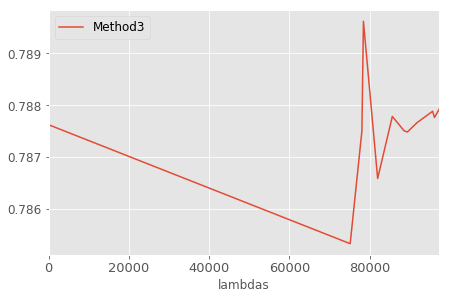

In [20]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

mean_acc_grouped_by_lmbda.plot(y='Method3')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.show()

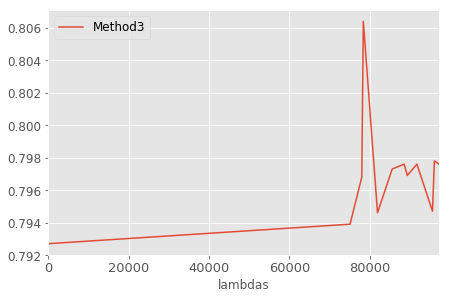

In [21]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

max_acc_grouped_by_lmbda.plot(y='Method3')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.show()

### Init the writer with $\lambda$s (7.5, 8.75)

In [9]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_sh_11lmbdas_ar1_3lyrs_he1_75_875', sess.graph)

### Generate $\lambda$s

In [10]:
np.random.seed(100)
n_lmbdas = 11
a = np.random.uniform(low=7.5, high=8.75, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[8.17925618 7.84796173 8.03064699 8.55597017 7.50589857 7.6519614
 8.33843636 8.53231594 7.67088324 8.21886666 8.61415244]
()
[75058.98570239 76519.61400979 76708.83237106 78479.61731367
 80306.46988436 81792.56177239 82188.66661784 83384.36355908
 85323.15943881 85559.701654   86141.5244289 ]
()
([0, 75058.98570238716, 76519.61400978893, 76708.83237106192, 78479.61731367245, 80306.46988436417, 81792.56177238707, 82188.66661784063, 83384.36355908474, 85323.15943881309, 85559.7016539988, 86141.5244289033, 0, 75058.98570238716, 76519.61400978893, 76708.83237106192, 78479.61731367245, 80306.46988436417, 81792.56177238707, 82188.66661784063, 83384.36355908474, 85323.15943881309, 85559.7016539988, 86141.5244289033, 0, 75058.98570238716, 76519.61400978893, 76708.83237106192, 78479.61731367245, 80306.46988436417, 81792.56177238707, 82188.66661784063, 83384.36355908474, 85323.15943881309, 85559.7016539988, 86141.5244289033, 0, 75058.98570238716, 76519.61400978893, 76708.83237106192, 78479.6173

In [11]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(60, 60)


In [12]:
np.array_equal(np_weights[0], np_weights[11])

True

In [13]:
np.array_equal(np_weights[0], np_weights[12])

False

### Commence training

In [ ]:
START_TIME = time.time()
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()
print('Total time:{}'.format(time.time()-START_TIME))

Training with lmbda:0, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.9